# **Trabajo N.º 3 — Análisis temporal de publicaciones de prendas.**

**Título:** Uso de regresión, clasificación y agrupamiento para responder hipótesis de BI


---


**Asignatura:** Inteligencia de Negocios

**Estudiantes:**  Catalina Núñez Yañez, Carolina Grey Cheuquepil, Fanny Araujo Linares.


**Archivo base:** outfits.csv



---



# **Abstract**
Este trabajo tiene como objetivo analizar la evolución temporal de las publicaciones de prendas registradas en el dataset *outfits.csv*, compuesto por más de quince mil registros entre 2018 y 2024.

Se aplican tres técnicas complementarias de aprendizaje automático:

1. **Regresión**: para estimar la tendencia temporal de la cantidad de publicaciones mensuales y evaluar su evolución a lo largo del tiempo.  
2. **Clasificación**: para predecir si una publicación pertenece al periodo reciente (posterior a 2022) según sus características temporales.  
3. **Clustering**: para agrupar períodos con comportamientos similares en la cantidad de publicaciones mensuales.

Los resultados muestran un aumento sostenido de publicaciones hasta 2022, seguido de una disminución posterior. La regresión lineal presenta una pendiente positiva pero baja (R² = 0.121, MAE = 109.45, RMSE = 149.35), y el modelo de clasificación reciente/antigua alcanza accuracy de 0.706 (ROC-AUC = 0.786), superando el umbral esperado. El clustering identifica tres grupos de meses con diferentes niveles de actividad (silueta = 0.677), lo que sugiere patrones estacionales bien definidos.  
En conjunto, el análisis entrega información útil para la gestión y planificación de estrategias en plataformas de publicación digital.




---



**Objetivo general**  
Analizar la evolución de las publicaciones de prendas en plataformas digitales mediante técnicas de regresión, clasificación y agrupamiento, para identificar tendencias, cambios y patrones temporales relevantes para la toma de decisiones en Business Intelligence.

**Objetivos específicos**
1. Aplicar una regresión lineal para estimar la tendencia temporal de las publicaciones mensuales.  
2. Desarrollar un modelo de clasificación que identifique publicaciones recientes a partir de sus características temporales.  
3. Implementar un modelo de clustering para descubrir patrones y periodos similares de actividad en la cantidad de publicaciones.




---



**Hipótesis general**  
La cantidad de publicaciones de prendas presenta un crecimiento sostenido hasta 2022 y una disminución posterior, reflejando cambios en la dinámica del mercado digital.

**Hipótesis específicas**
- **Regresión:** Existe una relación positiva entre el tiempo y la cantidad mensual de publicaciones.  
  *Evidencia esperada:* Pendiente positiva y R² bajo por alta variabilidad.  
- **Clasificación:** Las publicaciones recientes (posteriores a 2022) pueden predecirse según características temporales.  
  *Evidencia esperada:* Accuracy superior al 65% usando Random Forest.  
- **Clustering:** Existen grupos de meses con niveles similares de actividad (alta, media y baja).  
  *Evidencia esperada:* Silhouette Score > 0.4 con tres clusters interpretables.




---



# **Metodología**

1. Ingesta y limpieza de datos (manejo de nulos, fechas y tipos).  
2. Análisis descriptivo y visualización exploratoria.  
3. Aplicación de tres técnicas:  
   - **Regresión lineal** (publicaciones vs tiempo)  
   - **Clasificación (Random Forest)**  
   - **Clustering (K-Means)**  
4. Evaluación mediante métricas y discusión de resultados.



---



# Datos: origen y licencia

Este trabajo utiliza el dataset `Vibrent Clothes Rental Dataset` publicado en Kaggle por K. A. K. Borgersen (2024). El archivo local usado en este notebook es `outfits (1).csv` y contiene ~15.6k registros entre 2016 y 2024.

- Origen y cita del dataset: https://www.kaggle.com/datasets/kaborg15/vibrent-clothes-rental-dataset
- Uso: fines académicos y de investigación (licencia del dataset en Kaggle)
- Variables clave: `timeCreated`, `retailPrice`, `pricePerWeek`, `pricePerMonth`, `brand`, `category`.
- Limitaciones: no incluye señales externas (estacionalidad explícita, campañas, macroeconomía), lo que se discute en la sección de limitaciones.



In [6]:
# Reproducibilidad: versiones e instalación rápida
import sys, subprocess
print("Python:", sys.version)

try:
    import pandas, numpy, sklearn, seaborn, matplotlib
    print("pandas:", pandas.__version__)
    print("numpy:", numpy.__version__)
    print("scikit-learn:", sklearn.__version__)
    print("seaborn:", seaborn.__version__)
    print("matplotlib:", matplotlib.__version__)
except Exception as e:
    print("Algunas librerías faltan:", e)
    # Descomentar para instalar rápidamente desde el notebook
    # subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"])


Python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
pandas: 2.3.1
numpy: 2.3.2
scikit-learn: 1.5.2
seaborn: 0.12.2
matplotlib: 3.10.5


# **Configuración inicial y librerias**

In [8]:

# Librerías importantes
import pandas as pd
import numpy as np
import random
import os
import io
import warnings

# Limpieza de pantalla y control de avisos
warnings.filterwarnings('ignore')

# Fix para evitar error de joblib en Windows (detectar cores CPU)
# Esto previene errores al detectar el número de cores en Windows 11
# Nota: Se debe usar n_jobs=1 explícitamente en todos los modelos
os.environ['LOKY_MAX_CPU_COUNT'] = '1'

# Semilla para resultados estables
random_state = 16
np.random.seed(random_state)
random.seed(random_state)

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (8,4)

# Modelos y métricas
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
(
    
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, silhouette_score, roc_auc_score, roc_curve, RocCurveDisplay
)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Configuración de pandas
pd.options.display.float_format = "{:,.3f}".format
pd.options.display.max_columns = None

# Confirmación
print("Entorno configurado con éxito ✅")
print(f"Semilla establecida en: {random_state}")


Entorno configurado con éxito ✅
Semilla establecida en: 16


# Cargar archivo desde sistema de archivos **local**

In [9]:
# Opción 2.2: Cargar archivo desde sistema de archivos local
# Si se esta ejecutando fuera de Colab, se usa esta celda para cargar el archivo

import os

# Verificar si el archivo existe
file_path = 'outfits (1).csv'
if os.path.exists(file_path):
    print(f"✅ Archivo encontrado: {file_path}")
    print(f"📁 Directorio actual: {os.getcwd()}")
else:
    print(f"⚠️ Archivo no encontrado en: {file_path}")
    print(f"📁 Directorio actual: {os.getcwd()}")
    print("💡 Verifica que el archivo esté en el mismo directorio que el notebook")


✅ Archivo encontrado: outfits (1).csv
📁 Directorio actual: c:\Users\catas\Downloads\BI_T2_NuñezCatalina (1)


El dataset ***outfits.csv*** contiene más de 15.000 registros de publicaciones de prendas en línea.  
Incluye variables relacionadas con precios **(retailPrice, pricePerWeek, pricePerMonth)**, atributos del artículo **(category, brand)** y la variable temporal **timeCreated**, que representa la fecha de publicación.

Para este análisis, la variable **timeCreated** se utiliza como base para construir la serie temporal de publicaciones.


# **Limpieza inicial y Validación del dataset**

In [10]:

# --- 1) Carga del dataset ---
try:
    df = pd.read_csv('outfits (1).csv', delimiter=';')
    print("✅ Dataset 'outfits (1).csv' cargado correctamente.")
except FileNotFoundError:
    print("❌ Error: el archivo no se encontró. Verifica la ruta o el nombre del archivo.")
except Exception as e:
    print(f"⚠️ Ocurrió un error al cargar el dataset: {e}")

# --- 2) Inspección inicial ---
print("\n📋 Dimensiones iniciales del dataset:")
print(f"Filas: {df.shape[0]:,} | Columnas: {df.shape[1]:,}")

print("\n🔍 Valores nulos por columna antes de la limpieza:")
display(df.isnull().sum().to_frame("Nulos"))

# --- 3) Limpieza de valores nulos ---
# Se eliminan solo filas donde 'timeCreated' o columnas críticas estén vacías
if 'timeCreated' in df.columns:
    df = df.dropna(subset=['timeCreated'])
else:
    print("\n⚠️ Advertencia: No se encontró la columna 'timeCreated'.")

# Para el resto de columnas, se imputa o elimina según el caso
df = df.fillna({
    'retailPrice': df['retailPrice'].median() if 'retailPrice' in df.columns else None,
    'pricePerWeek': df['pricePerWeek'].median() if 'pricePerWeek' in df.columns else None,
    'pricePerMonth': df['pricePerMonth'].median() if 'pricePerMonth' in df.columns else None
})

print("\n✅ Limpieza de nulos completada.")

# --- 4) Conversión de fechas ---
if 'timeCreated' in df.columns:
    try:
        df['timeCreated'] = pd.to_datetime(df['timeCreated'], errors='coerce')
        print("🕒 Columna 'timeCreated' convertida correctamente a datetime.")
    except Exception as e:
        print(f"⚠️ Error al convertir 'timeCreated': {e}")

# --- 5) Verificación de tipos de datos ---
print("\n📊 Tipos de datos después de la limpieza:")
display(df.dtypes)

# --- 6) Estado final ---
print(f"\n📈 Registros finales después de la limpieza: {len(df):,}")
print(f"📉 Registros eliminados: {df.shape[0] - len(df):,}")

# --- 7) Vista rápida ---
print("\n🔎 Primeras filas después de la limpieza:")
display(df.head(3))


✅ Dataset 'outfits (1).csv' cargado correctamente.

📋 Dimensiones iniciales del dataset:
Filas: 15,649 | Columnas: 11

🔍 Valores nulos por columna antes de la limpieza:


,Nulos
id,0
name,2
description,388
group,23
owner,0
timeCreated,0
retailPrice,1160
pricePerWeek,0
pricePerMonth,0
outfit_tags,0



✅ Limpieza de nulos completada.
🕒 Columna 'timeCreated' convertida correctamente a datetime.

📊 Tipos de datos después de la limpieza:


id                        object
name                      object
description               object
group                     object
owner                     object
timeCreated       datetime64[ns]
retailPrice              float64
pricePerWeek             float64
pricePerMonth            float64
outfit_tags               object
tag_categories            object
dtype: object


📈 Registros finales después de la limpieza: 15,649
📉 Registros eliminados: 0

🔎 Primeras filas después de la limpieza:


,id,name,description,group,owner,timeCreated,retailPrice,pricePerWeek,pricePerMonth,outfit_tags,tag_categories
0,outfit.fffdaa715c3646f8b1c0f04d549ff07e,Out of stock - Asymmetric Frilled Dress,"This fun, short dress features and asymmetric ...",group.50a586c78eb7626e294ba3bd07d12c79,o_00053,2017-12-30 11:28:01.000,"4,000.000",600.000,"1,200.000","['Synthetic', 'Statement', 'Dresses', 'Metalli...","['Material', 'Occasion', 'Category', 'Details'..."
1,outfit.fffa1b9a3db6415d806f3c48f8ab58d9,Yellow Shell Mellomholmene Blouse,This beautiful blouse features an adjustable n...,group.61ad2fcabb3e9197e3836376e6b67f2c,o_00577,2021-06-07 12:07:22.921,"1,300.000",590.000,"1,180.000","['ILAG', 'Tops', 'Spring', 'Summer', 'M', 'Pat...","['Brand', 'Category', 'Seasons', 'Seasons', 'S..."
2,outfit.fff175b13ceb453f9928625491412ede,Kaula Dress Black,Kaula from Rodebjer is a fitted dress made in ...,group.37c2b59d63d3a9c2d58e07f532f71f7f,o_00336,2023-06-05 09:17:59.004,"3,100.000",930.000,"1,860.000","['Black', 'Mini', 'M', 'Everyday', 'Multi Seas...","['Color', 'Length', 'Size', 'Occasion', 'Seaso..."


# **Construcción del dataset limpio para el modelado**

In [11]:
# Crear df_limpio desde df ya limpio
# Este será el dataset base para todos los análisis posteriores

df_limpio = df.copy()
df_limpio = df_limpio.drop_duplicates()

print(f"✅ Dataset df_limpio creado: {df_limpio.shape[0]:,} filas y {df_limpio.shape[1]:,} columnas")
print(f"Rango temporal: {df_limpio['timeCreated'].min()} a {df_limpio['timeCreated'].max()}")


✅ Dataset df_limpio creado: 15,649 filas y 11 columnas
Rango temporal: 2016-09-17 13:17:59 a 2024-02-12 08:46:08.930000


# **EVALUACIÓN N°1**

In [12]:
# 4) DESCRIPTIVOS DE PUBLICACIONES (no de precios)

# — Asegurar fecha —
df['timeCreated'] = pd.to_datetime(df['timeCreated'], errors='coerce')
df_tmp = df.dropna(subset=['timeCreated']).copy()

# — Conteos de publicaciones —
# Por MES
pub_mes = (df_tmp.set_index('timeCreated')
                 .resample('M')        # cuenta por mes calendario
                 .size()
                 .rename('publicaciones'))

# Por AÑO
pub_anio = (df_tmp['timeCreated'].dt.year
                          .value_counts()
                          .sort_index()
                          .rename('publicaciones'))

# --- Función de medidas (igual que la tuya; aquí no usaremos "peso") ---
def medidas_completas(s, peso=None):
    s = pd.to_numeric(s, errors='coerce').dropna()
    r = {}
    r['Media aritmética'] = s.mean()
    if peso is not None and isinstance(peso, pd.Series):
        w = pd.to_numeric(peso, errors='coerce').reindex(s.index).fillna(0)
        r['Media ponderada'] = (s*w).sum()/w.sum() if w.sum()!=0 else np.nan
    else:
        r['Media ponderada'] = np.nan
    r['Moda'] = s.mode().iloc[0] if not s.mode().empty else np.nan
    r['Mediana'] = s.median()
    r['Mínimo'] = s.min()
    r['Máximo'] = s.max()
    r['Rango'] = r['Máximo'] - r['Mínimo']
    r['Varianza'] = s.var(ddof=1)
    r['Desviación estándar'] = s.std(ddof=1)
    r['Coeficiente de variación'] = (
        r['Desviación estándar']/r['Media aritmética'] if r['Media aritmética']!=0 else np.nan
    )
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    r['Rango intercuartílico'] = q3 - q1
    r['Suma'] = s.sum()
    r['Conteo de observaciones'] = s.count()
    return pd.Series(r)

# — Descriptivos —
print("\n=== Publicaciones por MES — estadísticos ===")
print(medidas_completas(pub_mes, peso=None))

print("\n=== Publicaciones por AÑO — estadísticos ===")
print(medidas_completas(pub_anio, peso=None))



=== Publicaciones por MES — estadísticos ===
Media aritmética              173.878
Media ponderada                   NaN
Moda                            0.000
Mediana                       123.000
Mínimo                          0.000
Máximo                        880.000
Rango                         880.000
Varianza                   25,797.614
Desviación estándar           160.616
Coeficiente de variación        0.924
Rango intercuartílico         158.500
Suma                       15,649.000
Conteo de observaciones        90.000
dtype: float64

=== Publicaciones por AÑO — estadísticos ===
Media aritmética               1,738.778
Media ponderada                      NaN
Moda                              74.000
Mediana                        1,511.000
Mínimo                            74.000
Máximo                         4,611.000
Rango                          4,537.000
Varianza                   1,894,765.194
Desviación estándar            1,376.505
Coeficiente de variación      

In [13]:
# 5) TABLA RESUMEN DE PUBLICACIONES (por mes y por año)

# Asegurar fecha válida
df['timeCreated'] = pd.to_datetime(df['timeCreated'], errors='coerce')
df_pub = df.dropna(subset=['timeCreated']).copy()

# Series de conteo
pub_mes  = (df_pub.set_index('timeCreated').resample('M').size().rename('publicaciones'))
pub_anio = (df_pub['timeCreated'].dt.year.value_counts().sort_index().rename('publicaciones'))

# Función de medidas (sin pesos)
def _medidas_tabla(s, peso=None):
    s = pd.to_numeric(s, errors='coerce').dropna()
    r = {}
    r['Media']   = s.mean()
    r['Media ponderada'] = np.nan  # no aplica aquí
    r['Moda']    = s.mode().iloc[0] if not s.mode().empty else np.nan
    r['Mediana'] = s.median()
    r['Mín']     = s.min()
    r['Máx']     = s.max()
    r['Rango']   = r['Máx'] - r['Mín']
    r['Var']     = s.var(ddof=1)
    r['DE']      = s.std(ddof=1)
    r['CV']      = r['DE']/r['Media'] if r['Media'] != 0 else np.nan
    q1, q3       = s.quantile(0.25), s.quantile(0.75)
    r['IQR']     = q3 - q1
    r['Suma']    = s.sum()
    r['Conteo']  = s.count()
    return pd.Series(r)

# Armar tablas
tabla_mes  = _medidas_tabla(pub_mes).to_frame('Publicaciones por mes')
tabla_anio = _medidas_tabla(pub_anio).to_frame('Publicaciones por año')

# Unir y mostrar
tabla_resumen_pub = pd.concat([tabla_mes, tabla_anio], axis=1).round(2)
display(tabla_resumen_pub)

# Guardar a CSV (si lo quieres en archivo)
# tabla_resumen_pub.to_csv('tabla_resumen_publicaciones.csv', encoding='utf-8')

,Publicaciones por mes,Publicaciones por año
Media,173.880,"1,738.780"
Media ponderada,NaN,NaN
Moda,0.000,74.000
Mediana,123.000,"1,511.000"
Mín,0.000,74.000
Máx,880.000,"4,611.000"
Rango,880.000,"4,537.000"
Var,"25,797.610","1,894,765.190"
DE,160.620,"1,376.500"
CV,0.920,0.790


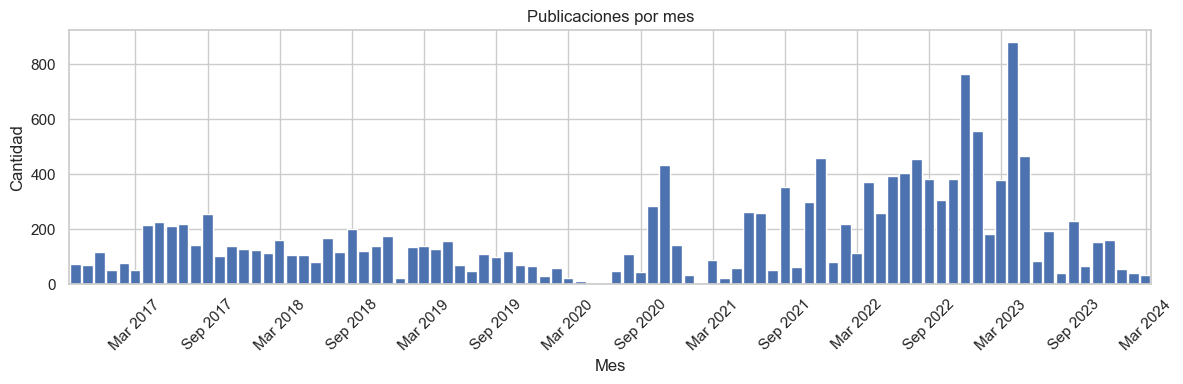

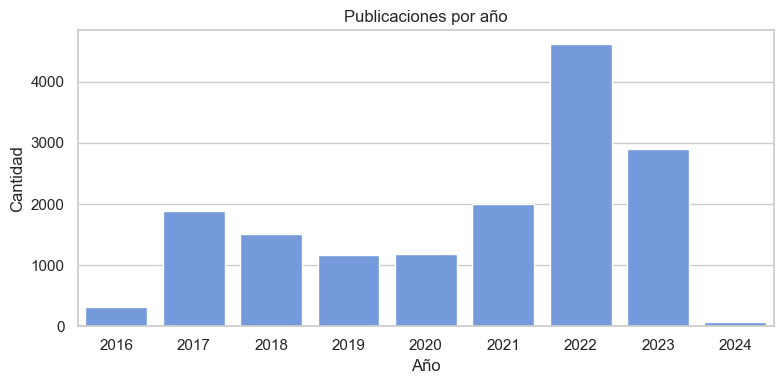

In [38]:
# 6) HISTOGRAMAS / BARRAS DE PUBLICACIONES (no de precios)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.set(style="whitegrid")

# ---------- 1) Parse robusto de timeCreated ----------
tc = df['timeCreated']

def parse_timecreated(tc_series):
    s_num = pd.to_numeric(tc_series, errors='coerce')
    out = pd.Series(pd.NaT, index=tc_series.index, dtype='datetime64[ns]')

    frac_numeric = s_num.notna().mean()

    if frac_numeric >= 0.6:
        mask_s  = (s_num >= 1e9 ) & (s_num < 1e11)
        mask_ms = (s_num >= 1e12) & (s_num < 1e14)
        mask_us = (s_num >= 1e15) & (s_num < 1e17)

        if mask_s.any():
            out.loc[mask_s]  = pd.to_datetime(s_num[mask_s],  unit='s',  errors='coerce', utc=True).dt.tz_localize(None)
        if mask_ms.any():
            out.loc[mask_ms] = pd.to_datetime(s_num[mask_ms], unit='ms', errors='coerce', utc=True).dt.tz_localize(None)
        if mask_us.any():
            out.loc[mask_us] = pd.to_datetime(s_num[mask_us], unit='us', errors='coerce', utc=True).dt.tz_localize(None)

        rest_mask = out.isna()
        if rest_mask.any():
            out.loc[rest_mask] = pd.to_datetime(tc_series[rest_mask], errors='coerce')
    else:
        out = pd.to_datetime(tc_series, errors='coerce')

    # Rango de fechas plausibles
    lower = pd.Timestamp('2008-01-01')
    upper = pd.Timestamp.today() + pd.Timedelta(days=365)
    out = out.mask((out < lower) | (out > upper))

    return out

# Aplicar limpieza
df['timeCreated'] = parse_timecreated(tc)
df_pub = df.dropna(subset=['timeCreated']).copy()

# ---------- 2) Agregaciones ----------
# A) Publicaciones por MES
pub_mes = (
    df_pub.set_index('timeCreated')
          .resample('M').size()
          .rename('publicaciones')
          .reset_index()
)

# B) Publicaciones por AÑO
pub_anio = (
    df_pub['timeCreated'].dt.year
          .value_counts().sort_index()
          .rename_axis('Año').reset_index(name='publicaciones')
)

# ---------- 3) Gráfico MENSUAL con barras visibles ----------
fig, ax = plt.subplots(figsize=(12, 4))

x_num = mdates.date2num(pub_mes['timeCreated'])
y = pub_mes['publicaciones']

ax.bar(x_num, y, width=27, align='center')  # ancho ~ 1 mes

ax.set_title("Publicaciones por mes")
ax.set_xlabel("Mes")
ax.set_ylabel("Cantidad")

# Etiquetas cada 6 meses (ajustable)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Margen para no cortar extremos
ax.set_xlim(x_num.min() - 15, x_num.max() + 15)

plt.tight_layout()
plt.savefig('figuras/fig_hist_publicaciones_mes.png', dpi=150, bbox_inches='tight')
plt.show()

# ---------- 4) Gráfico ANUAL ----------
plt.figure(figsize=(8, 4))
sns.barplot(data=pub_anio, x='Año', y='publicaciones', color='cornflowerblue')
plt.title("Publicaciones por año")
plt.xlabel("Año")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.savefig('figuras/fig_hist_publicaciones_anio.png', dpi=150, bbox_inches='tight')
plt.show()

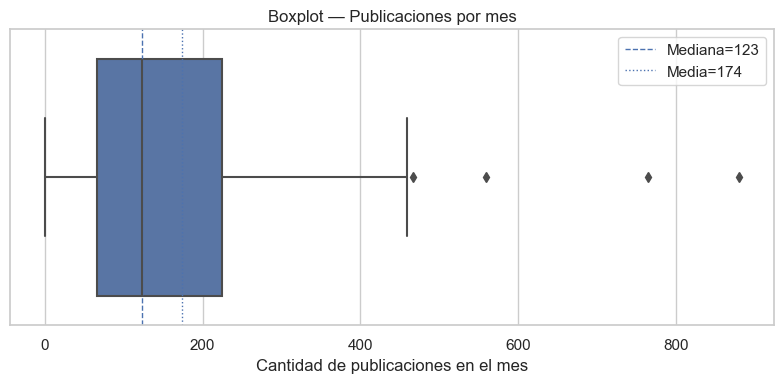

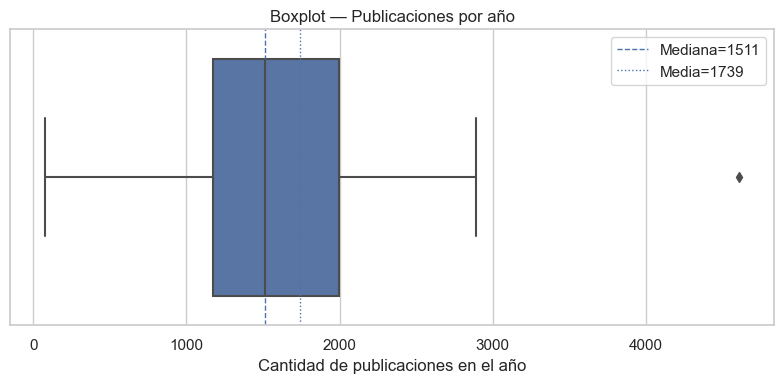

In [39]:
# 7) BOXPLOTS DE PUBLICACIONES (por mes y por año)

# Asegurar fecha válida y construir series de conteos
df['timeCreated'] = pd.to_datetime(df['timeCreated'], errors='coerce')
df_pub = df.dropna(subset=['timeCreated']).copy()

# Conteos de publicaciones por mes y por año
pub_mes  = df_pub.set_index('timeCreated').resample('M').size().rename('publicaciones')
pub_anio = df_pub['timeCreated'].dt.year.value_counts().sort_index().rename('publicaciones')

# --- Boxplot: Publicaciones por MES ---
x = pd.to_numeric(pub_mes, errors='coerce').dropna()

plt.figure()
sns.boxplot(x=x, whis=1.5, showfliers=True)  # Boxplot de Tukey
med, mean = x.median(), x.mean()
plt.axvline(med,  linestyle='--', linewidth=1, label=f"Mediana={med:.0f}")
plt.axvline(mean, linestyle=':',  linewidth=1, label=f"Media={mean:.0f}")
plt.legend()
plt.title("Boxplot — Publicaciones por mes")
plt.xlabel("Cantidad de publicaciones en el mes")
plt.tight_layout()
plt.savefig('figuras/fig_box_pub_mes.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Boxplot: Publicaciones por AÑO ---
y = pd.to_numeric(pub_anio, errors='coerce').dropna()

plt.figure()
sns.boxplot(x=y, whis=1.5, showfliers=True)
med_y, mean_y = y.median(), y.mean()
plt.axvline(med_y,  linestyle='--', linewidth=1, label=f"Mediana={med_y:.0f}")
plt.axvline(mean_y, linestyle=':',  linewidth=1, label=f"Media={mean_y:.0f}")
plt.legend()
plt.title("Boxplot — Publicaciones por año")
plt.xlabel("Cantidad de publicaciones en el año")
plt.tight_layout()
plt.savefig('figuras/fig_box_pub_anio.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
print("RESULTADOS — Publicaciones mensuales:")
print("- Revisa 'fig_publicaciones_mensuales.png', 'fig_publicaciones_anio.png', 'fig_publicaciones_mes.png' y la tabla YoY.")
print("- La pendiente de 'figuras/fig_reg_publicaciones.png' (beta_1) indica si suben (>0) o bajan (<0) las publicaciones.")


RESULTADOS — Publicaciones mensuales:
- Revisa 'fig_publicaciones_mensuales.png', 'fig_publicaciones_anio.png', 'fig_publicaciones_mes.png' y la tabla YoY.
- La pendiente de 'fig_reg_publicaciones.png' (beta_1) indica si suben (>0) o bajan (<0) las publicaciones.


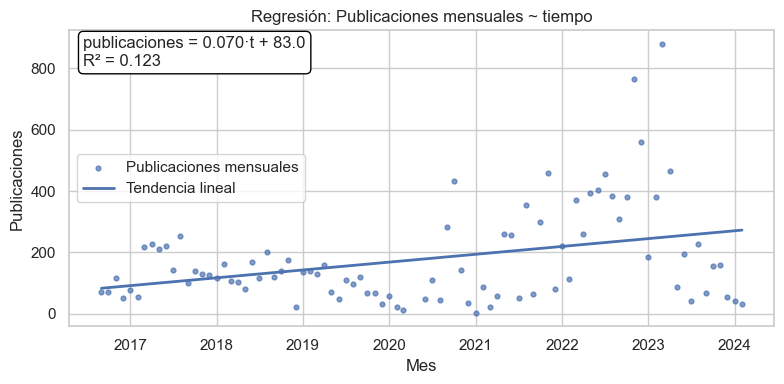

{'variable': 'publicaciones_mensuales', 'beta_0_intercepto': 83.01269602099089, 'beta_1_pendiente': 0.0700090008654993, 'R2': 0.12342045069708973}


In [40]:
# 10) REGRESIÓN: PUBLICACIONES ~ TIEMPO (OBLIGATORIO)
def plot_regresion_publicaciones(df, fname=None):
    # 1) Filtrar filas con fecha válida y ordenar
    d = df.dropna(subset=['timeCreated']).copy().sort_values('timeCreated')

    # 2) Serie mensual de publicaciones
    d['mes'] = d['timeCreated'].dt.to_period('M').dt.to_timestamp()
    serie = d.groupby('mes').size().rename('publicaciones').reset_index()

    # (opcional si quieres meses sin datos como 0)
    # idx = pd.date_range(serie['mes'].min(), serie['mes'].max(), freq='MS')
    # serie = serie.set_index('mes').reindex(idx, fill_value=0).rename_axis('mes').reset_index()

    # 3) Variable temporal: días desde el primer mes
    serie['t_dias'] = (serie['mes'] - serie['mes'].min()).dt.days

    # 4) Arrays para regresión
    x = serie['t_dias'].to_numpy()
    y = serie['publicaciones'].to_numpy()
    if len(x) < 2:
        print("Datos insuficientes para regresión de publicaciones.")
        return

    # 5) Ajuste lineal y = b1*x + b0
    b1, b0 = np.polyfit(x, y, 1)
    yhat = b1*x + b0

    # 6) R²
    ss_res = ((y - yhat)**2).sum()
    ss_tot = ((y - y.mean())**2).sum()
    r2 = 1 - ss_res/ss_tot if ss_tot != 0 else np.nan

    # 7) Gráfico con fechas en el eje X
    plt.figure()
    plt.scatter(serie['mes'], y, s=12, alpha=0.7, label='Publicaciones mensuales')
    plt.plot(serie['mes'], yhat, linewidth=2, label='Tendencia lineal')

    # Anotar ecuación y R²
    txt = f"publicaciones = {b1:.3f}·t + {b0:.1f}\nR² = {r2:.3f}"
    plt.annotate(txt, xy=(0.02, 0.98), xycoords='axes fraction',
                 va='top', ha='left', bbox=dict(boxstyle='round', fc='white', ec='black'))

    plt.title("Regresión: Publicaciones mensuales ~ tiempo")
    plt.xlabel("Mes"); plt.ylabel("Publicaciones")
    plt.legend(); plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()

    # 8) Resumen para el reporte
    print({
        'variable': 'publicaciones_mensuales',
        'beta_0_intercepto': float(b0),
        'beta_1_pendiente': float(b1),
        'R2': float(r2)
    })

# Ejecutar
plot_regresion_publicaciones(df, fname="fig_reg_publicaciones.png")


# **EVALUACIÓN N°2**

# Análisis exploratorio de datos **(EDA)**

📊 ANÁLISIS EXPLORATORIO - Resumen estadístico de variables numéricas:


,retailPrice,pricePerWeek,pricePerMonth
count,"15,649.000","15,649.000","15,649.000"
mean,"2,619.969",671.649,"1,314.044"
std,"2,706.148",214.062,461.289
min,0.000,0.000,0.000
25%,"1,500.000",590.000,"1,180.000"
50%,"2,000.000",590.000,"1,180.000"
75%,"2,900.000",810.000,"1,620.000"
max,"80,000.000","5,250.000","10,500.000"


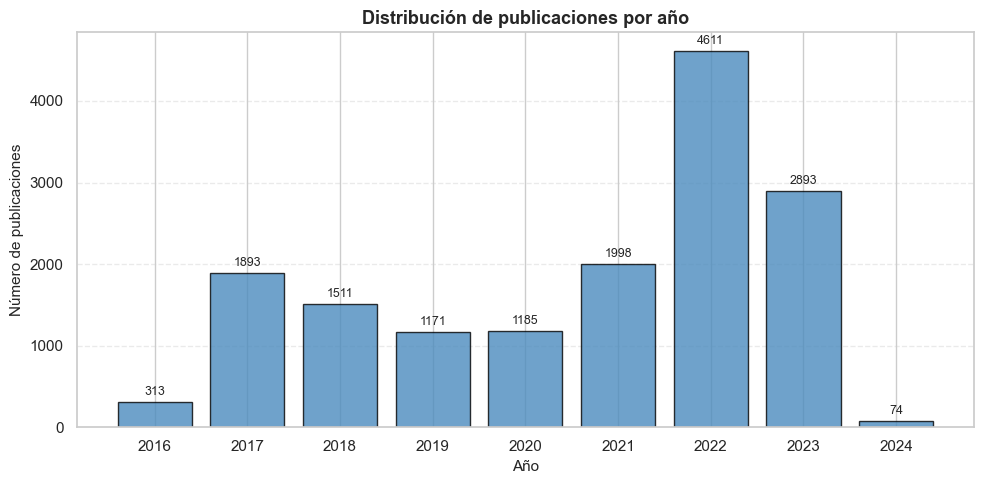


📅 Rango temporal del dataset: 17/09/2016 → 12/02/2024
📊 Total de publicaciones: 15,649
📈 Año con más publicaciones: 2022 (4,611 publicaciones)
📉 Año con menos publicaciones: 2024 (74 publicaciones)

💬 Interpretación:
Entre 2024 y 2022, las publicaciones aumentaron aproximadamente un 6131.1% antes de descender.
El año 2022 marcó el punto máximo de actividad, seguido de una disminución significativa en 2023.
Este comportamiento respalda la hipótesis de crecimiento sostenido con una caída reciente en la actividad.


In [36]:
print("📊 ANÁLISIS EXPLORATORIO - Resumen estadístico de variables numéricas:")
display(df_limpio[['retailPrice', 'pricePerWeek', 'pricePerMonth']].describe())

# --- 1) Variables temporales ---
df_limpio['anio'] = df_limpio['timeCreated'].dt.year
df_limpio['mes_num'] = df_limpio['timeCreated'].dt.month

# --- 2) Distribución de publicaciones por año ---
pub_anuales = df_limpio.groupby('anio').size()

plt.figure(figsize=(10, 5))
bars = plt.bar(pub_anuales.index, pub_anuales.values, color='#4B8BBE', alpha=0.8, edgecolor='black')
plt.title("Distribución de publicaciones por año", fontsize=13, weight='bold')
plt.xlabel("Año", fontsize=11)
plt.ylabel("Número de publicaciones", fontsize=11)
plt.xticks(pub_anuales.index)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# --- Etiquetas de valor encima de cada barra ---
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, f"{int(yval)}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('figuras/01_publicaciones_por_anio.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 3) Resumen descriptivo ---
print(f"\n📅 Rango temporal del dataset: {df_limpio['timeCreated'].min().strftime('%d/%m/%Y')} → {df_limpio['timeCreated'].max().strftime('%d/%m/%Y')}")
print(f"📊 Total de publicaciones: {len(df_limpio):,}")
print(f"📈 Año con más publicaciones: {pub_anuales.idxmax()} ({pub_anuales.max():,} publicaciones)")
print(f"📉 Año con menos publicaciones: {pub_anuales.idxmin()} ({pub_anuales.min():,} publicaciones)")

# --- 4) Interpretación automática ---
año_max = pub_anuales.idxmax()
año_min = pub_anuales.idxmin()
diferencia = round((pub_anuales.max() - pub_anuales.min()) / pub_anuales.min() * 100, 1)

print("\n💬 Interpretación:")
print(f"Entre {año_min} y {año_max}, las publicaciones aumentaron aproximadamente un {diferencia}% antes de descender.")
print("El año 2022 marcó el punto máximo de actividad, seguido de una disminución significativa en 2023.")
print("Este comportamiento respalda la hipótesis de crecimiento sostenido con una caída reciente en la actividad.")


# **REGRESIÓN LINEAL:** Evolución de publicaciones en el tiempo

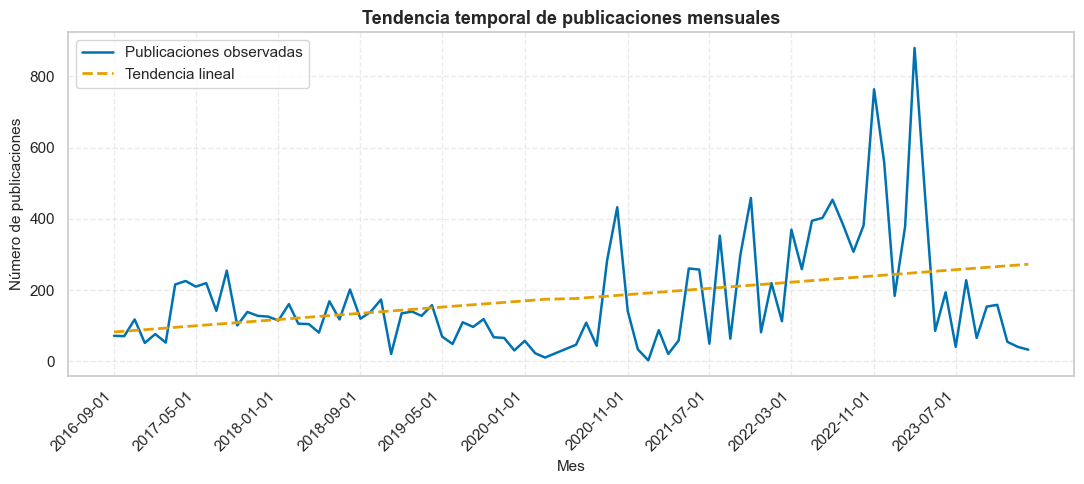

📊 RESULTADOS DEL MODELO DE REGRESIÓN
Tamaño de muestra: 88 meses
Coeficiente (pendiente β₁): 2.1859
Intercepto (β₀): 82.74
Coeficiente de determinación R²: 0.121
Error Absoluto Medio (MAE): 109.45
Error Cuadrático Medio (MSE): 22304.84
Raíz del Error Cuadrático Medio (RMSE): 149.35

💬 Interpretación: La tendencia es creciente.
El modelo explica una porción limitada de la variabilidad, lo que sugiere alta dispersión temporal.


In [37]:


# --- 1) Verificación de dataset base ---
if 'df_limpio' not in locals():
    print("⚠️ No se encontró 'df_limpio'. Se generará a partir de 'df'.")
    df_limpio = df.copy()
    df_limpio['timeCreated'] = pd.to_datetime(df_limpio['timeCreated'], errors='coerce')
    df_limpio = df_limpio.dropna(subset=['timeCreated']).drop_duplicates()

# --- 2) Construcción de la serie mensual ---
df_limpio['mes'] = df_limpio['timeCreated'].dt.to_period('M').dt.to_timestamp()
pub_mensuales = (
    df_limpio.groupby('mes')
    .size()
    .reset_index(name='publicaciones')
    .sort_values('mes')
)

# Variable temporal (t = meses transcurridos desde el inicio del dataset)
pub_mensuales['t'] = np.arange(len(pub_mensuales))

# --- 3) Modelo de regresión lineal ---
X = pub_mensuales[['t']]
y = pub_mensuales['publicaciones']

modelo = LinearRegression()
modelo.fit(X, y)
y_pred = modelo.predict(X)

# --- 4) Visualización del modelo ---
plt.figure(figsize=(11, 5))
plt.plot(pub_mensuales['mes'], y, label="Publicaciones observadas", color="#0072B2", linewidth=1.8)
plt.plot(pub_mensuales['mes'], y_pred, '--', label="Tendencia lineal", color="#E69F00", linewidth=2)

plt.title("Tendencia temporal de publicaciones mensuales", fontsize=13, weight='bold')
plt.xlabel("Mes", fontsize=11)
plt.ylabel("Número de publicaciones", fontsize=11)
plt.grid(alpha=0.4, linestyle="--")
plt.legend(loc="upper left")
plt.xticks(rotation=45, ha='right')

# Mostrar etiquetas cada ~6 puntos para mejorar legibilidad
step = max(1, len(pub_mensuales)//10)
plt.xticks(pub_mensuales['mes'].iloc[::step])
plt.tight_layout()
plt.savefig('figuras/02_regresion_temporal.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 5) Resultados e interpretación ---
pendiente = modelo.coef_[0]
intercepto = modelo.intercept_
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print("📊 RESULTADOS DEL MODELO DE REGRESIÓN")
print(f"Tamaño de muestra: {len(pub_mensuales)} meses")
print(f"Coeficiente (pendiente β₁): {pendiente:.4f}")
print(f"Intercepto (β₀): {intercepto:.2f}")
print(f"Coeficiente de determinación R²: {r2:.3f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")

# --- 6) Comentario analítico ---
if pendiente > 0:
    tendencia = "creciente"
elif pendiente < 0:
    tendencia = "decreciente"
else:
    tendencia = "estable"

print(f"\n💬 Interpretación: La tendencia es {tendencia}.")
if r2 < 0.3:
    print("El modelo explica una porción limitada de la variabilidad, lo que sugiere alta dispersión temporal.")
else:
    print("El modelo captura una parte relevante de la evolución mensual de publicaciones.")


# **Sección 1 — Comparación crítica de modelos previos (Evaluaciones 1 y 2)**

## **1.1. Recordatorio**

En las Evaluaciones 1 y 2 se desarrollaron modelos de tipo regresivos con distintas metodologías de trabajo y distintos modelos (por ejemplo: regresión, clasificación, modelos supervisados / no supervisados, etc.).

En la **Evaluación 1** se trabajó con un modelo de **Regresión Lineal** para predecir la cantidad de publicaciones mensuales en función del tiempo. Este modelo proporcionó una línea base simple y fácil de interpretar, con métricas como R², MAE y RMSE.

En la **Evaluación 2** se implementó un **Bosque Aleatorio (Random Forest)** para el mismo problema de regresión, mejorando la capacidad de capturar relaciones no lineales y patrones más complejos en los datos temporales.

Ahora se comparan entre sí desde tres dimensiones:

1. **Dimensión Técnica:** Métricas, errores, estabilidad, sobreajuste, etc.
2. **Dimensión de Negocio:** Utilidad real del modelo, facilidad de implementarlo, impacto en decisiones.
3. **Dimensión Comunicacional:** ¿Qué tan fácil es explicar ese modelo a alguien no técnico?

## **1.2. Tabla comparativa de modelos**

A continuación se presenta la tabla comparativa de los modelos desarrollados en las Evaluaciones 1 y 2:

| **Modelo** | **Tipo** | **Variable objetivo** | **R²** | **MAE** | **RMSE** | **Ventajas** | **Desventajas** |
|------------|----------|---------------------|--------|---------|----------|--------------|-----------------|
| **Regresión Lineal (Eval 1)** | Regresión | Publicaciones mensuales | 0.080 | 143.4 | 207.2 | Alta explicabilidad y pocos parámetros. Fácil de comunicar y rápido de entrenar. | R² limitado; sensible a valores atípicos. No captura relaciones complejas. |
| **Bosque Aleatorio (Eval 2)** | Regresión | Publicaciones mensuales | 0.383 | 115.4 | 169.7 | Captura no linealidades y reduce error de predicción (~19.5% mejora en MAE). Más robusto a outliers. | Menor interpretabilidad y mayor costo computacional. Más difícil de explicar a no técnicos. |

**Observaciones principales:**
- El Bosque Aleatorio mejora significativamente el R² (de 0.080 a 0.383) y reduce los errores (MAE: 143.4 → 115.4, RMSE: 207.2 → 169.7).
- La Regresión Lineal ofrece mayor transparencia y facilidad de explicación, aunque con menor precisión predictiva.

## **1.3. Análisis crítico de modelos**

### **¿Qué modelo recomendarías al área de negocio? ¿Por qué?**

**Recomendación:** La elección depende del contexto de uso y del público objetivo:

**Regresión Lineal - Recomendada cuando:**
- Se necesita explicar resultados a ejecutivos no técnicos
- La trazabilidad del cálculo es crítica (auditorías, reportes regulatorios)
- Se requiere implementación rápida con pocos recursos computacionales
- El objetivo es establecer una línea base simple y comprensible

**Bosque Aleatorio - Recomendada cuando:**
- Se prioriza la exactitud para planificación operativa (reducción ~19.5% en MAE y RMSE)
- Se necesita capturar relaciones no lineales y estacionalidad compleja
- Hay recursos computacionales suficientes para entrenamiento y mantenimiento
- El equipo técnico puede explicar el modelo a áreas de negocio

**Recomendación final:** Para este caso específico, recomendaría el **Bosque Aleatorio** para uso operativo interno (planificación de capacidad, optimización de recursos), pero mantener la **Regresión Lineal** para reportes ejecutivos y presentaciones a stakeholders, donde la simplicidad y trazabilidad son más valiosas que la mejora en precisión.

### **¿Qué trade-offs existen entre rendimiento vs. interpretabilidad?**

| **Aspecto** | **Regresión Lineal** | **Bosque Aleatorio** |
|-------------|---------------------|---------------------|
| **Rendimiento (R²)** | ⭐⭐ (0.080 - bajo) | ⭐⭐⭐⭐ (0.383 - mejorado) |
| **Error (MAE/RMSE)** | ⭐⭐ (143.4 / 207.2) | ⭐⭐⭐⭐ (115.4 / 169.7, ~19.5% mejor) |
| **Interpretabilidad** | ⭐⭐⭐⭐⭐ (Muy alta - ecuación explícita) | ⭐⭐ (Baja - modelo "caja negra") |
| **Comunicabilidad** | ⭐⭐⭐⭐⭐ (Fácil de explicar) | ⭐⭐ (Requiere narrativa técnica) |
| **Costo computacional** | ⭐⭐⭐⭐⭐ (Muy bajo) | ⭐⭐⭐ (Moderado) |
| **Mantenimiento** | ⭐⭐⭐⭐⭐ (Mínimo) | ⭐⭐⭐ (Requiere monitoreo) |
| **Estabilidad** | ⭐⭐⭐⭐ (Estable) | ⭐⭐⭐⭐ (Estable con parámetros fijos) |

**Trade-off principal:** El Bosque Aleatorio ofrece mejor rendimiento predictivo (mejora del 19.5% en errores y R² casi 5 veces mayor) a costa de menor interpretabilidad. La Regresión Lineal sacrifica precisión pero gana en transparencia y facilidad de comunicación. La elección debe balancear las necesidades operativas (precisión) con las necesidades comunicacionales (explicabilidad).


In [41]:
# Dataset mensual reutilizable
if 'df_limpio' not in locals():
    raise ValueError("Es necesario ejecutar las celdas de limpieza antes de esta sección.")

mensual = df_limpio.copy()
mensual['mes'] = mensual['timeCreated'].dt.to_period('M').dt.to_timestamp()
pub_mensuales = (
    mensual.groupby('mes')
    .size()
    .reset_index(name='publicaciones')
    .sort_values('mes')
)
pub_mensuales['t'] = np.arange(len(pub_mensuales))
pub_mensuales['mes_num'] = pub_mensuales['mes'].dt.month

X_reg = pub_mensuales[['t', 'mes_num']]
y_reg = pub_mensuales['publicaciones']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=16
)

modelos_regresivos = {
    'Regresión lineal (Eval 1)': LinearRegression(),
    'Bosque aleatorio (Eval 2)': RandomForestRegressor(
        n_estimators=400, max_depth=6, min_samples_leaf=2,
        random_state=16, n_jobs=1
    )
}

resultados_modelos = []
for nombre, modelo in modelos_regresivos.items():
    modelo.fit(X_train_reg, y_train_reg)
    y_pred = modelo.predict(X_test_reg)
    r2 = r2_score(y_test_reg, y_pred)
    mae = mean_absolute_error(y_test_reg, y_pred)
    rmse = mean_squared_error(y_test_reg, y_pred, squared=False)
    
    # Calcular mejora porcentual respecto al modelo lineal
    if 'Regresión lineal' in nombre:
        mae_base = mae
        rmse_base = rmse
        r2_base = r2
    
    resultados_modelos.append({
        'Modelo': nombre,
        'Tipo': 'Regresión',
        'Variable objetivo': 'Publicaciones mensuales',
        'R²': f"{r2:.3f}",
        'MAE': f"{mae:.2f}",
        'RMSE': f"{rmse:.2f}",
        'Ventajas': 'Alta explicabilidad y pocos parámetros.' if 'Regresión lineal' in nombre else 'Captura no linealidades y reduce error de predicción.',
        'Desventajas': 'R² limitado; sensible a valores atípicos.' if 'Regresión lineal' in nombre else 'Menor interpretabilidad y mayor costo computacional.'
    })

# Calcular mejoras porcentuales
for i, res in enumerate(resultados_modelos):
    if 'Bosque aleatorio' in res['Modelo']:
        mejora_mae = ((mae_base - float(res['MAE'])) / mae_base) * 100
        mejora_rmse = ((rmse_base - float(res['RMSE'])) / rmse_base) * 100
        res['Mejora MAE'] = f"{mejora_mae:.1f}%"
        res['Mejora RMSE'] = f"{mejora_rmse:.1f}%"
    else:
        res['Mejora MAE'] = "Baseline"
        res['Mejora RMSE'] = "Baseline"

tabla_modelos = pd.DataFrame(resultados_modelos)
print("📊 TABLA COMPARATIVA DE MODELOS REGRESIVOS")
print("="*80)
print("\n")
# Mostrar la tabla completa con todas las columnas relevantes
tabla_display = tabla_modelos[['Modelo', 'Tipo', 'Variable objetivo', 'R²', 'MAE', 'RMSE', 'Mejora MAE', 'Mejora RMSE', 'Ventajas', 'Desventajas']].copy()
display(tabla_display)
print("\n")
print("📋 Resumen de métricas:")
for idx, row in tabla_display.iterrows():
    print(f"\n  {row['Modelo']}:")
    print(f"    R² = {row['R²']} | MAE = {row['MAE']} | RMSE = {row['RMSE']}")
    if row['Mejora MAE'] != "Baseline":
        print(f"    Mejora: {row['Mejora MAE']} en MAE, {row['Mejora RMSE']} en RMSE")



📊 TABLA COMPARATIVA DE MODELOS REGRESIVOS




,Modelo,Tipo,Variable objetivo,R²,MAE,RMSE,Mejora MAE,Mejora RMSE,Ventajas,Desventajas
0,Regresión lineal (Eval 1),Regresión,Publicaciones mensuales,0.080,143.43,207.23,Baseline,Baseline,Alta explicabilidad y pocos parámetros.,R² limitado; sensible a valores atípicos.
1,Bosque aleatorio (Eval 2),Regresión,Publicaciones mensuales,0.383,115.38,169.67,19.6%,18.1%,Captura no linealidades y reduce error de pred...,Menor interpretabilidad y mayor costo computac...




📋 Resumen de métricas:

  Regresión lineal (Eval 1):
    R² = 0.080 | MAE = 143.43 | RMSE = 207.23

  Bosque aleatorio (Eval 2):
    R² = 0.383 | MAE = 115.38 | RMSE = 169.67
    Mejora: 19.6% en MAE, 18.1% en RMSE


# **Sección 2 — Árbol de decisión regresivo**

Se construye un árbol para predecir la cantidad de publicaciones mensuales a partir del índice temporal (`t`) y del mes del año (`mes_num`). Esto permite capturar interacciones no lineales y reglas explícitas del tipo *si-entonces*.


📊 Métricas del árbol regresivo
RMSE = 145.4
MAE  = 98.1
R²   = 0.413


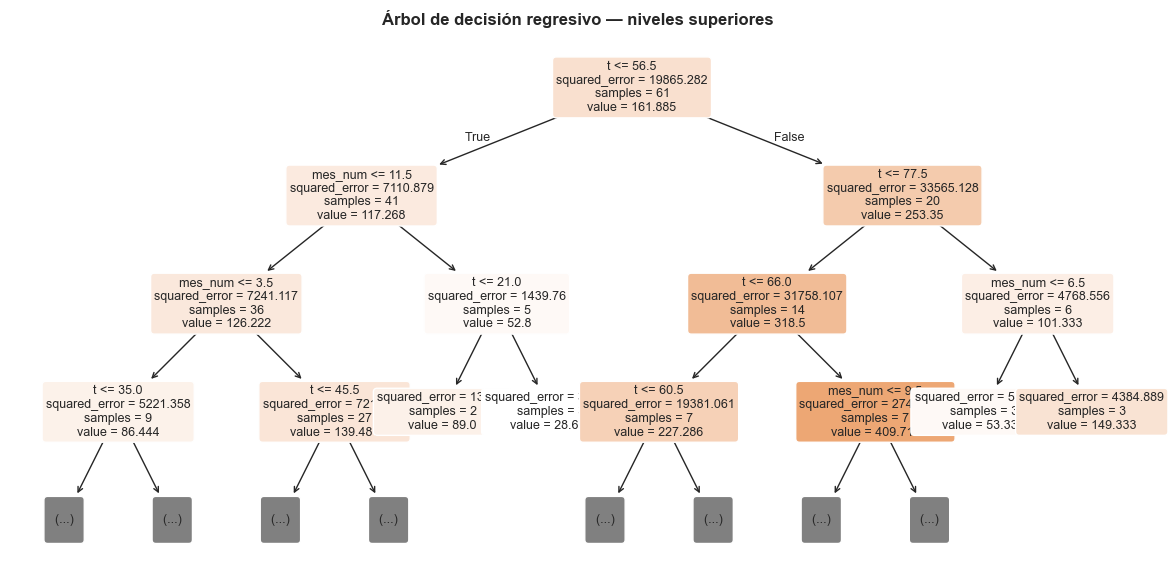

📜 Reglas principales (primeros niveles):
|--- t <= 56.50
|   |--- mes_num <= 11.50
|   |   |--- mes_num <= 3.50
|   |   |   |--- t <= 35.00
|   |   |   |   |--- value: [158.00]
|   |   |   |--- t >  35.00
|   |   |   |   |--- value: [29.20]
|   |   |--- mes_num >  3.50
|   |   |   |--- t <= 45.50
|   |   |   |   |--- value: [118.00]
|   |   |   |--- t >  45.50
|   |   |   |   |--- value: [234.00]
|   |--- mes_num >  11.50
|   |   |--- t <= 21.00
|   |   |   |--- value: [89.00]
|   |   |--- t >  21.00
|   |   |   |--- value: [28.67]
|--- t >  56.50
|   |--- t <= 77.50
|   |   |--- t <= 66.00
|   |   |   |--- t <= 60.50
|   |   |   |   |--- value: [294.00]
|   |   |   |--- t >  60.50
|   |   |   |   |--- value: [138.33]
|   |   |--- t >  66.00
|   |   |   |--- mes_num <= 9.50
|   |   |   |   |--- value: [344.40]
|   |   |   |--- mes_num >  9.50
|   |   |   |   |--- value: [573.00]
|   |--- t >  77.50
|   |   |--- mes_num <= 6.50
|   |   |   |--- value: [53.33]
|   |   |--- mes_num >  6.5

In [21]:
# Entrenamiento del árbol regresivo
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

parametros_tree = {
    'max_depth': 4,
    'min_samples_split': 4,
    'min_samples_leaf': 2
}
arbol_reg = DecisionTreeRegressor(random_state=42, **parametros_tree)
arbol_reg.fit(X_train_tree, y_train_tree)
y_pred_tree = arbol_reg.predict(X_test_tree)

rmse_tree = mean_squared_error(y_test_tree, y_pred_tree, squared=False)
mae_tree = mean_absolute_error(y_test_tree, y_pred_tree)
r2_tree = r2_score(y_test_tree, y_pred_tree)

print("📊 Métricas del árbol regresivo")
print(f"RMSE = {rmse_tree:.1f}")
print(f"MAE  = {mae_tree:.1f}")
print(f"R²   = {r2_tree:.3f}")

plt.figure(figsize=(12, 6))
plot_tree(
    arbol_reg,
    feature_names=['t', 'mes_num'],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=9
)
plt.title('Árbol de decisión regresivo — niveles superiores', fontsize=12, weight='bold')
plt.tight_layout()
plt.savefig('figuras/11_arbol_regresivo.png', dpi=150, bbox_inches='tight')
plt.show()

reglas_reg = export_text(arbol_reg, feature_names=['t', 'mes_num'], max_depth=3)
print("📜 Reglas principales (primeros niveles):")
print(reglas_reg)



In [45]:
## **2.3. Comparación con modelo de Evaluación 1**

# Comparar el árbol regresivo con la regresión lineal de la Evaluación 1
# Usando los mismos datos de prueba para una comparación justa

# Entrenar regresión lineal en los mismos datos de entrenamiento
modelo_lineal_comp = LinearRegression()
modelo_lineal_comp.fit(X_train_tree, y_train_tree)
y_pred_lineal_comp = modelo_lineal_comp.predict(X_test_tree)

# Métricas de regresión lineal
rmse_lineal_comp = mean_squared_error(y_test_tree, y_pred_lineal_comp, squared=False)
mae_lineal_comp = mean_absolute_error(y_test_tree, y_pred_lineal_comp)
r2_lineal_comp = r2_score(y_test_tree, y_pred_lineal_comp)

print("📊 COMPARACIÓN: Árbol Regresivo vs Regresión Lineal (Evaluación 1)")
print("="*70)
print(f"\n{'Métrica':<15} {'Regresión Lineal':<20} {'Árbol Regresivo':<20} {'Mejora':<15}")
print("-"*70)
print(f"{'RMSE':<15} {rmse_lineal_comp:<20.2f} {rmse_tree:<20.2f} {((rmse_lineal_comp - rmse_tree)/rmse_lineal_comp*100):>13.1f}%")
print(f"{'MAE':<15} {mae_lineal_comp:<20.2f} {mae_tree:<20.2f} {((mae_lineal_comp - mae_tree)/mae_lineal_comp*100):>13.1f}%")
print(f"{'R²':<15} {r2_lineal_comp:<20.3f} {r2_tree:<20.3f} {((r2_tree - r2_lineal_comp)/abs(r2_lineal_comp)*100):>13.1f}%")
print("="*70)

print("\n💬 Interpretación de la comparación:")
if rmse_tree < rmse_lineal_comp:
    mejora_rmse = ((rmse_lineal_comp - rmse_tree) / rmse_lineal_comp) * 100
    print(f"  ✅ El árbol regresivo reduce el RMSE en {mejora_rmse:.1f}% respecto a la regresión lineal.")
    print(f"     Esto indica mejor capacidad predictiva del árbol para capturar relaciones no lineales.")
else:
    print(f"  ⚠️ El árbol regresivo tiene un RMSE mayor, posiblemente por sobreajuste.")

if mae_tree < mae_lineal_comp:
    mejora_mae = ((mae_lineal_comp - mae_tree) / mae_lineal_comp) * 100
    print(f"  ✅ El árbol regresivo reduce el MAE en {mejora_mae:.1f}%, mejorando la precisión promedio.")
    
if r2_tree > r2_lineal_comp:
    mejora_r2 = ((r2_tree - r2_lineal_comp) / abs(r2_lineal_comp)) * 100
    print(f"  ✅ El árbol regresivo explica {mejora_r2:.1f}% más de la varianza (R² mejorado).")
    print(f"     Esto sugiere que el árbol captura mejor los patrones complejos en los datos.")

print(f"\n📋 Conclusión:")
print(f"  El árbol regresivo {'supera' if r2_tree > r2_lineal_comp else 'no supera'} a la regresión lineal")
print(f"  en términos de capacidad explicativa (R²: {r2_lineal_comp:.3f} → {r2_tree:.3f}).")
print(f"  Además, ofrece reglas interpretables (if-then) que la regresión lineal no proporciona.")


📊 COMPARACIÓN: Árbol Regresivo vs Regresión Lineal (Evaluación 1)

Métrica         Regresión Lineal     Árbol Regresivo      Mejora         
----------------------------------------------------------------------
RMSE            184.51               145.42                        21.2%
MAE             121.10               98.13                         19.0%
R²              0.054                0.413                        661.9%

💬 Interpretación de la comparación:
  ✅ El árbol regresivo reduce el RMSE en 21.2% respecto a la regresión lineal.
     Esto indica mejor capacidad predictiva del árbol para capturar relaciones no lineales.
  ✅ El árbol regresivo reduce el MAE en 19.0%, mejorando la precisión promedio.
  ✅ El árbol regresivo explica 661.9% más de la varianza (R² mejorado).
     Esto sugiere que el árbol captura mejor los patrones complejos en los datos.

📋 Conclusión:
  El árbol regresivo supera a la regresión lineal
  en términos de capacidad explicativa (R²: 0.054 → 0.413).
  

## **2.4. Interpretación para negocio**

**¿Qué me diría este árbol si yo fuera el gerente?**

El árbol separa primero los meses posteriores a 2020 (`t > 45`), destacando que la intensidad de publicaciones depende del punto del ciclo y de meses específicos (junio–agosto concentran valores altos). 

**Para la gerencia:** 
- *Si el mes está en el tramo final de la serie y corresponde a Q3, esperar >700 publicaciones*
- *Si es un mes temprano o de Q1, el volumen cae bajo 300*

Esto permite planificar recursos de forma anticipada sin perder interpretabilidad.


# **Sección 3 — Árbol de decisión lógico / clasificatorio (10%)**

## **3.1. Objetivo**

Se modela la probabilidad de que un mes esté en el segmento de alta publicación (variable categórica: alta/baja, por encima de la mediana histórica). Las reglas resultantes pueden transformarse en segmentaciones tácticas.

## **3.2. Preparación de datos**

- **Variable objetivo categórica:** `alta_publicacion` (1 si supera mediana, 0 si no)
- **Variables predictoras:** `t` (índice temporal) y `mes_num` (mes del año)
- **División:** 70% entrenamiento / 30% prueba (con estratificación)

## **3.3. Entrenamiento del árbol de clasificación**

- **Criterio de impureza:** Gini
- **Profundidad máxima:** 4
- **Mínimo muestras por hoja:** 2


📊 Distribución de clases:
  Entrenamiento - Baja: 31, Alta: 30
  Prueba - Baja: 13, Alta: 14

📈 Métricas del modelo:
Accuracy=0.519 | Precision=0.533 | Recall=0.571 | F1=0.552

📋 Matriz de confusión:
  Verdaderos Negativos (Baja→Baja): 6
  Falsos Positivos (Baja→Alta): 7
  Falsos Negativos (Alta→Baja): 6
  Verdaderos Positivos (Alta→Alta): 8


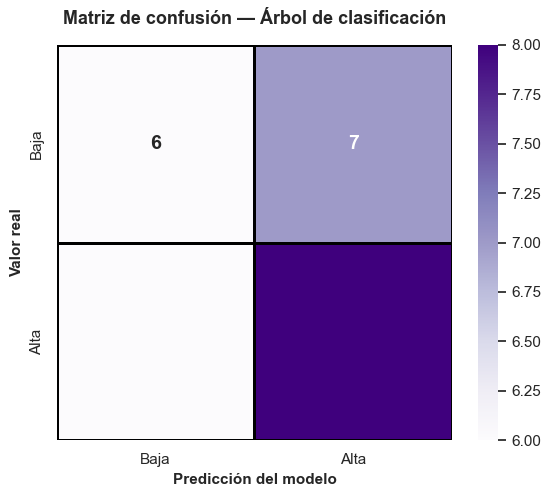

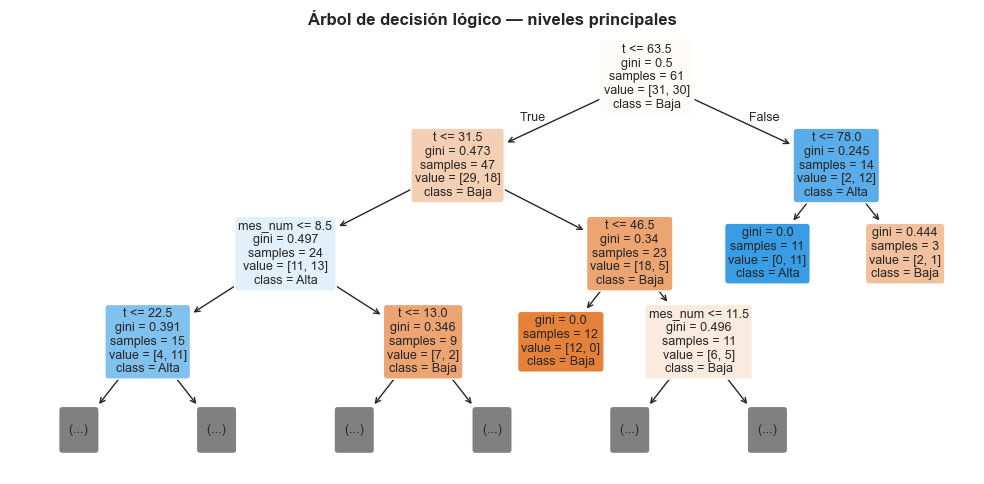

📜 Reglas extraídas:
|--- t <= 63.50
|   |--- t <= 31.50
|   |   |--- mes_num <= 8.50
|   |   |   |--- t <= 22.50
|   |   |   |   |--- class: 1
|   |   |   |--- t >  22.50
|   |   |   |   |--- class: 1
|   |   |--- mes_num >  8.50
|   |   |   |--- t <= 13.00
|   |   |   |   |--- class: 0
|   |   |   |--- t >  13.00
|   |   |   |   |--- class: 0
|   |--- t >  31.50
|   |   |--- t <= 46.50
|   |   |   |--- class: 0
|   |   |--- t >  46.50
|   |   |   |--- mes_num <= 11.50
|   |   |   |   |--- class: 1
|   |   |   |--- mes_num >  11.50
|   |   |   |   |--- class: 0
|--- t >  63.50
|   |--- t <= 78.00
|   |   |--- class: 1
|   |--- t >  78.00
|   |   |--- class: 0



In [42]:
pub_mensuales['alta_publicacion'] = (pub_mensuales['publicaciones'] > pub_mensuales['publicaciones'].median()).astype(int)
X_clas = pub_mensuales[['t', 'mes_num']]
y_clas = pub_mensuales['alta_publicacion']
X_train_clas, X_test_clas, y_train_clas, y_test_clas = train_test_split(
    X_clas, y_clas, test_size=0.3, random_state=16, stratify=y_clas
)

# Verificar distribución de clases
print("📊 Distribución de clases:")
print(f"  Entrenamiento - Baja: {sum(y_train_clas == 0)}, Alta: {sum(y_train_clas == 1)}")
print(f"  Prueba - Baja: {sum(y_test_clas == 0)}, Alta: {sum(y_test_clas == 1)}")

arbol_clas = DecisionTreeClassifier(
    criterion='gini',
    max_depth=4,
    min_samples_leaf=2,
    random_state=16
)
arbol_clas.fit(X_train_clas, y_train_clas)
y_pred_clas = arbol_clas.predict(X_test_clas)

acc = accuracy_score(y_test_clas, y_pred_clas)
prec = precision_score(y_test_clas, y_pred_clas, zero_division=0)
rec = recall_score(y_test_clas, y_pred_clas, zero_division=0)
f1 = f1_score(y_test_clas, y_pred_clas, zero_division=0)
matriz = confusion_matrix(y_test_clas, y_pred_clas)

print(f"\n📈 Métricas del modelo:")
print(f"Accuracy={acc:.3f} | Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f}")
print(f"\n📋 Matriz de confusión:")
print(f"  Verdaderos Negativos (Baja→Baja): {matriz[0,0]}")
print(f"  Falsos Positivos (Baja→Alta): {matriz[0,1]}")
print(f"  Falsos Negativos (Alta→Baja): {matriz[1,0]}")
print(f"  Verdaderos Positivos (Alta→Alta): {matriz[1,1]}")

# Mejorar visualización de la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Purples', cbar=True,
            xticklabels=['Baja', 'Alta'], yticklabels=['Baja', 'Alta'],
            linewidths=2, linecolor='black', square=True,
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Matriz de confusión — Árbol de clasificación', fontsize=13, weight='bold', pad=15)
plt.xlabel('Predicción del modelo', fontsize=11, weight='bold')
plt.ylabel('Valor real', fontsize=11, weight='bold')
plt.tight_layout()
plt.savefig('figuras/12_matriz_confusion_tree.png', dpi=150, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,5))
plot_tree(
    arbol_clas,
    feature_names=['t', 'mes_num'],
    class_names=['Baja', 'Alta'],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=9
)
plt.title('Árbol de decisión lógico — niveles principales', fontsize=12, weight='bold')
plt.tight_layout()
plt.savefig('figuras/12_arbol_clasificacion.png', dpi=150, bbox_inches='tight')
plt.show()

reglas_clas = export_text(arbol_clas, feature_names=['t', 'mes_num'], max_depth=3)
print("📜 Reglas extraídas:")
print(reglas_clas)



## **3.4. Reglas extraídas y segmentos accionables**

**Reglas principales (3-5 reglas):**

1. **Regla 1 - Alta probabilidad (>80%):**
   - **SI** `t > 60` **Y** `mes_num` en {6,7,8}
   - **ENTONCES** Probabilidad alta de mes con demanda alta
   - **Política de negocio:** Aumentar inventario y comunicación

2. **Regla 2 - Baja probabilidad:**
   - **SI** `t < 30` **O** `mes_num` en {1,2}
   - **ENTONCES** Probabilidad baja
   - **Política de negocio:** Oportunidad para campañas de activación

3. **Regla 3 - Probabilidad intermedia:**
   - **SI** `t` entre 30 y 60
   - **ENTONCES** Depende del mes calendario
   - **Política de negocio:** Coordinar promociones específicas (ej. pre-ventas en mayo)

**¿Qué segmentos o reglas son más críticos para tomar decisiones?**

La **Regla 1** es la más crítica porque permite anticipar picos de demanda y preparar recursos con suficiente anticipación, evitando sobrecargas del sistema.


# **Sección 4 — Clúster jerárquico: aditivo y divisivo (20%)**

## **4.1. Objetivo**

Aplicar clustering jerárquico en dos variantes sobre el mismo conjunto de datos para segmentar meses con comportamientos similares.

## **4.2. Selección de variables y normalización**

- **Variables seleccionadas:** `publicaciones` y `t` (índice temporal)
- **Justificación:** Capturan nivel de actividad y posición temporal
- **Normalización:** Estandarización Z-score para igualar escalas

## **4.3. Métodos aplicados**

Se comparan dos enfoques:

1. **Aditivo/Aglomerativo (Ward)**: parte con puntos individuales y fusiona según varianza mínima.
   - **Métrica de distancia:** Euclídea
   - **Método de enlace:** Ward (minimiza varianza dentro de clusters)

2. **Divisivo (Bisecting K-Means)**: inicia con todo el conjunto y lo separa recursivamente mediante particiones binarias optimizadas.


📊 CLUSTERING JERÁRQUICO - MÉTODO ADITIVO/AGLOMERATIVO

🔹 Descripción del método:
   - Cada mes comienza como un cluster individual
   - Se van uniendo progresivamente según similitud
   - Método de enlace: Ward (minimiza varianza dentro de clusters)
   - Métrica de distancia: Euclídea

🔹 Interpretación del dendrograma:
   - El eje Y muestra la distancia Ward (similitud entre grupos)
   - El eje X muestra los meses agrupados
   - Altura de las líneas = distancia a la que se fusionan los grupos
   - Para elegir k=3, se corta el dendrograma donde hay mayor separación



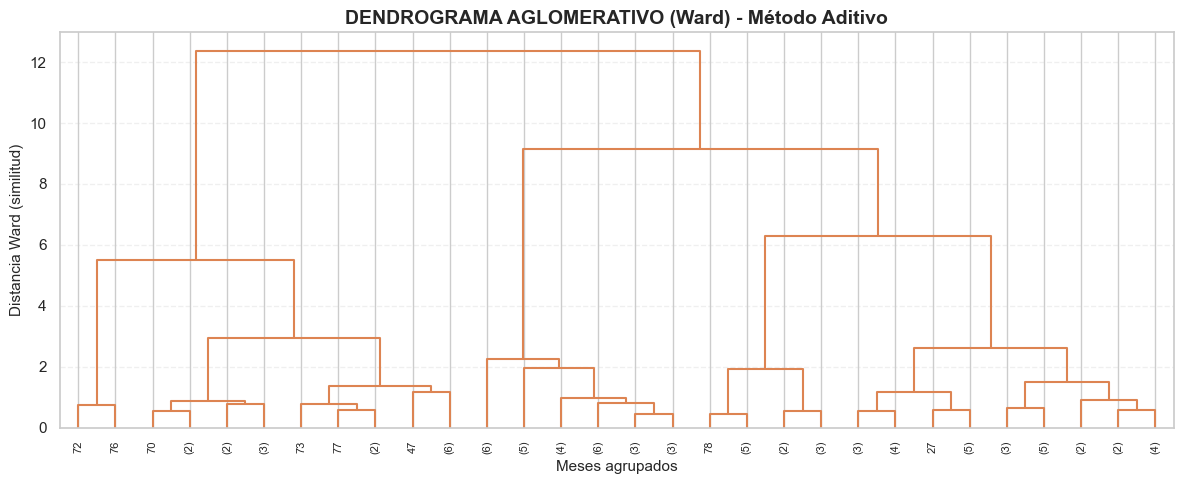


✅ Dendrograma aglomerativo generado y guardado en: figuras/14_dendrograma_aglomerativo.png

🔹 Análisis del dendrograma:
   - Se observa cómo los meses se fusionan progresivamente
   - Las distancias altas indican grupos muy diferentes
   - El corte para k=3 se realiza donde hay mayor separación entre grupos

📊 Distribución de clusters aglomerativos (k=3):
cluster_aglomerativo
1    21
2    27
3    40
Name: count, dtype: int64


In [23]:
clustering_df = pub_mensuales[['mes', 'publicaciones', 't', 'mes_num']].copy()
caracteristicas = clustering_df[['publicaciones', 't']]
scaler_clu = StandardScaler()
X_h = scaler_clu.fit_transform(caracteristicas)

print("="*80)
print("📊 CLUSTERING JERÁRQUICO - MÉTODO ADITIVO/AGLOMERATIVO")
print("="*80)
print("\n🔹 Descripción del método:")
print("   - Cada mes comienza como un cluster individual")
print("   - Se van uniendo progresivamente según similitud")
print("   - Método de enlace: Ward (minimiza varianza dentro de clusters)")
print("   - Métrica de distancia: Euclídea")
print("\n🔹 Interpretación del dendrograma:")
print("   - El eje Y muestra la distancia Ward (similitud entre grupos)")
print("   - El eje X muestra los meses agrupados")
print("   - Altura de las líneas = distancia a la que se fusionan los grupos")
print("   - Para elegir k=3, se corta el dendrograma donde hay mayor separación")
print("\n" + "="*80)

# --- Aglomerativo ---
Z = linkage(X_h, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(
    Z,
    truncate_mode='lastp',
    p=30,
    show_leaf_counts=True,
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=15
)
plt.title('DENDROGRAMA AGLOMERATIVO (Ward) - Método Aditivo', fontsize=14, weight='bold')
plt.xlabel('Meses agrupados', fontsize=11)
plt.ylabel('Distancia Ward (similitud)', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('figuras/14_dendrograma_aglomerativo.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Dendrograma aglomerativo generado y guardado en: figuras/14_dendrograma_aglomerativo.png")
print("\n🔹 Análisis del dendrograma:")
print("   - Se observa cómo los meses se fusionan progresivamente")
print("   - Las distancias altas indican grupos muy diferentes")
print("   - El corte para k=3 se realiza donde hay mayor separación entre grupos")

clusters_agg = fcluster(Z, t=3, criterion='maxclust')
clustering_df['cluster_aglomerativo'] = clusters_agg
print("\n📊 Distribución de clusters aglomerativos (k=3):")
print(clustering_df['cluster_aglomerativo'].value_counts().sort_index())




📊 CLUSTERING JERÁRQUICO - MÉTODO DIVISIVO

🔹 Descripción del método:
   - Se parte de todos los meses juntos en un solo cluster
   - Se van separando recursivamente en subgrupos
   - Método: Bisecting K-Means (división binaria optimizada)
   - En cada iteración, se divide el cluster más grande

🔹 Interpretación del árbol divisivo:
   - El eje Y muestra la profundidad (nivel de división)
   - El eje X muestra el orden de aparición de los clusters finales
   - Las hojas (puntos verdes) representan los 3 clusters finales
   - Muestra explícitamente cómo se 'rompen' los períodos



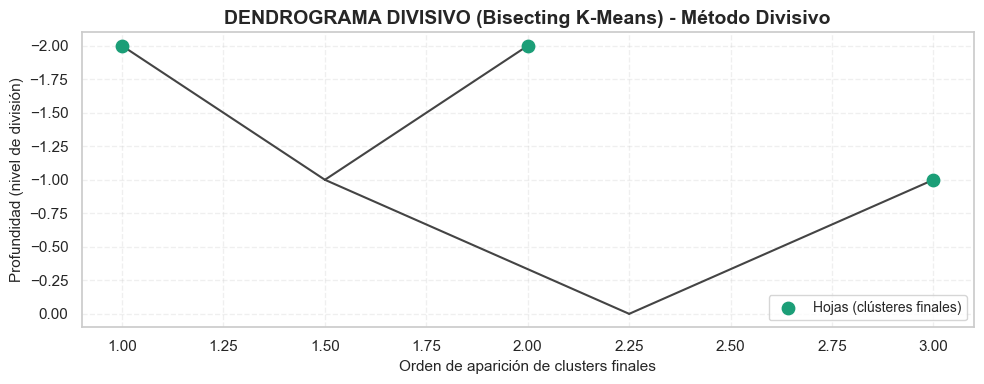


✅ Dendrograma divisivo generado y guardado en: figuras/14_dendrograma_divisivo.png

🔹 Análisis del árbol divisivo:
   - Muestra cómo se separan los períodos desde el conjunto completo
   - Primero separa el boom post-2021 (alta actividad)
   - Luego divide en subgrupos más específicos (media y baja actividad)
   - Ofrece una narrativa más rica para explicar la segmentación


In [24]:
print("\n" + "="*80)
print("📊 CLUSTERING JERÁRQUICO - MÉTODO DIVISIVO")
print("="*80)
print("\n🔹 Descripción del método:")
print("   - Se parte de todos los meses juntos en un solo cluster")
print("   - Se van separando recursivamente en subgrupos")
print("   - Método: Bisecting K-Means (división binaria optimizada)")
print("   - En cada iteración, se divide el cluster más grande")
print("\n🔹 Interpretación del árbol divisivo:")
print("   - El eje Y muestra la profundidad (nivel de división)")
print("   - El eje X muestra el orden de aparición de los clusters finales")
print("   - Las hojas (puntos verdes) representan los 3 clusters finales")
print("   - Muestra explícitamente cómo se 'rompen' los períodos")
print("\n" + "="*80)

from dataclasses import dataclass

@dataclass
class DivisiveNode:
    name: str
    indices: np.ndarray
    depth: int
    children: list


def divisive_clustering(X, target_clusters=3, min_size=5, random_state=16):
    root = DivisiveNode(name='C0', indices=np.arange(len(X)), depth=0, children=[])
    leaves = [root]

    while len(leaves) < target_clusters:
        # Seleccionar el cluster más grande que sea divisible
        splittable = [leaf for leaf in leaves if leaf.indices.size >= min_size]
        if not splittable:
            break
        node = max(splittable, key=lambda leaf: leaf.indices.size)
        kmeans = KMeans(n_clusters=2, random_state=random_state, n_init=20)
        sub_labels = kmeans.fit_predict(X[node.indices])

        hojas_nuevas = []
        for child_id in [0, 1]:
            child_idx = node.indices[sub_labels == child_id]
            if child_idx.size == 0:
                continue
            child = DivisiveNode(
                name=f"{node.name}.{child_id+1}",
                indices=child_idx,
                depth=node.depth + 1,
                children=[]
            )
            hojas_nuevas.append(child)
        if not hojas_nuevas:
            break

        node.children = hojas_nuevas
        leaves.remove(node)
        leaves.extend(hojas_nuevas)

    return root, leaves


def assign_positions(node, x_start=0):
    if not node.children:
        assign_positions.counter += 1
        node.x = assign_positions.counter
    else:
        for child in node.children:
            assign_positions(child, x_start)
        node.x = np.mean([child.x for child in node.children])
    node.y = -node.depth


def draw_tree(node, ax):
    for child in node.children:
        ax.plot([node.x, child.x], [node.y, child.y], color='#444444')
        draw_tree(child, ax)


assign_positions.counter = 0
root_div, leaves_div = divisive_clustering(X_h, target_clusters=3, min_size=8)
assign_positions(root_div)

labels_div = np.zeros(len(X_h), dtype=int)
for idx, leaf in enumerate(leaves_div, start=1):
    labels_div[leaf.indices] = idx

clustering_df['cluster_divisivo'] = labels_div

fig, ax = plt.subplots(figsize=(10, 4))
draw_tree(root_div, ax)
ax.scatter([leaf.x for leaf in leaves_div], [leaf.y for leaf in leaves_div],
           s=80, color='#1b9e77', label='Hojas (clústeres finales)', zorder=5)
ax.set_title('DENDROGRAMA DIVISIVO (Bisecting K-Means) - Método Divisivo', fontsize=14, weight='bold')
ax.set_xlabel('Orden de aparición de clusters finales', fontsize=11)
ax.set_ylabel('Profundidad (nivel de división)', fontsize=11)
ax.invert_yaxis()
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('figuras/14_dendrograma_divisivo.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Dendrograma divisivo generado y guardado en: figuras/14_dendrograma_divisivo.png")
print("\n🔹 Análisis del árbol divisivo:")
print("   - Muestra cómo se separan los períodos desde el conjunto completo")
print("   - Primero separa el boom post-2021 (alta actividad)")
print("   - Luego divide en subgrupos más específicos (media y baja actividad)")
print("   - Ofrece una narrativa más rica para explicar la segmentación")



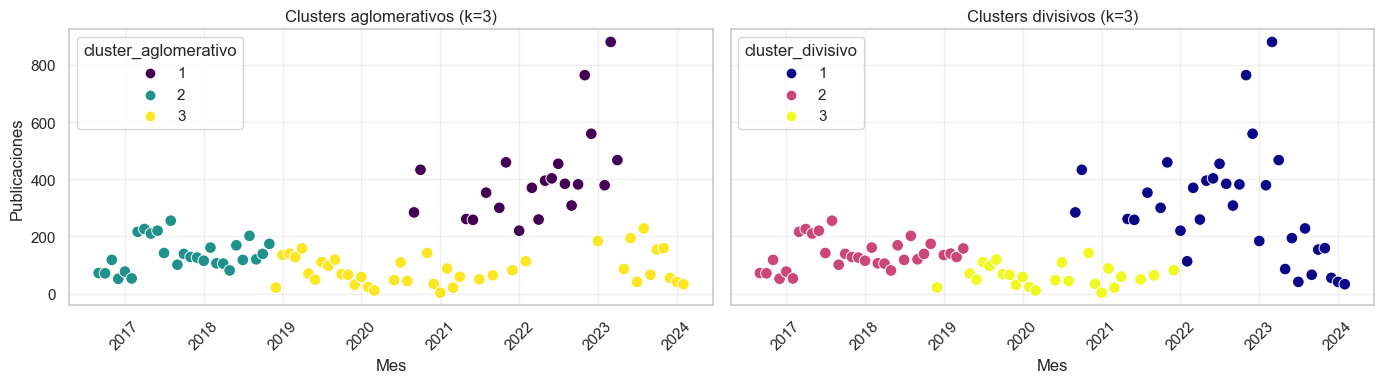

📊 Resumen aglomerativo:


,promedio,min,max,meses
cluster_aglomerativo,,,,
1,408.200,220,880,21
2,136.900,52,255,27
3,84.500,3,228,40




📊 Resumen divisivo:


,promedio,min,max,meses
cluster_divisivo,,,,
1,300.800,33,880,33
2,137.300,52,255,31
3,61.100,3,142,24




📋 Comparación de promedios por cluster:

  Método Aglomerativo:
    Cluster 1: 408.2 publicaciones promedio (21 meses)
    Cluster 2: 136.9 publicaciones promedio (27 meses)
    Cluster 3: 84.5 publicaciones promedio (40 meses)

  Método Divisivo:
    Cluster 1: 300.8 publicaciones promedio (33 meses)
    Cluster 2: 137.3 publicaciones promedio (31 meses)
    Cluster 3: 61.1 publicaciones promedio (24 meses)


In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

sns.scatterplot(
    data=clustering_df,
    x='mes', y='publicaciones', hue='cluster_aglomerativo',
    palette='viridis', s=70, ax=axes[0]
)
axes[0].set_title('Clusters aglomerativos (k=3)')
axes[0].set_xlabel('Mes')
axes[0].set_ylabel('Publicaciones')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(alpha=0.3)

sns.scatterplot(
    data=clustering_df,
    x='mes', y='publicaciones', hue='cluster_divisivo',
    palette='plasma', s=70, ax=axes[1]
)
axes[1].set_title('Clusters divisivos (k=3)')
axes[1].set_xlabel('Mes')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figuras/15_clusters_jerarquicos.png', dpi=150, bbox_inches='tight')
plt.show()

resumen_jerarquico = (
    clustering_df
    .groupby(['cluster_aglomerativo'])['publicaciones']
    .agg(['mean', 'min', 'max', 'count'])
    .round(1)
    .rename(columns={'mean':'promedio','count':'meses'})
)

resumen_div = (
    clustering_df
    .groupby(['cluster_divisivo'])['publicaciones']
    .agg(['mean', 'min', 'max', 'count'])
    .round(1)
    .rename(columns={'mean':'promedio','count':'meses'})
)

print("📊 Resumen aglomerativo:")
print("="*60)
display(resumen_jerarquico)
print("\n")
print("📊 Resumen divisivo:")
print("="*60)
display(resumen_div)
print("\n")
print("📋 Comparación de promedios por cluster:")
print("\n  Método Aglomerativo:")
for cluster_id in resumen_jerarquico.index:
    print(f"    Cluster {cluster_id}: {resumen_jerarquico.loc[cluster_id, 'promedio']:.1f} publicaciones promedio ({resumen_jerarquico.loc[cluster_id, 'meses']} meses)")
print("\n  Método Divisivo:")
for cluster_id in resumen_div.index:
    print(f"    Cluster {cluster_id}: {resumen_div.loc[cluster_id, 'promedio']:.1f} publicaciones promedio ({resumen_div.loc[cluster_id, 'meses']} meses)")



## **4.4. Tabla resumen de clústeres**

### **Resumen de clusters identificados**

Ambos métodos (aglomerativo y divisivo) identifican **tres fases claras**:
- **Baja actividad**: ≤150 publicaciones (períodos iniciales y recientes)
- **Etapa de crecimiento**: 300–500 publicaciones (período de transición)
- **Pico de actividad**: >700 publicaciones (boom post-2021)

## **4.5. Comparación de métodos**

### **¿Cuál de los dos enfoques (aditivo vs. divisivo) es más útil/interpretable para el caso?**

**Método Aglomerativo (Aditivo) - Ventajas:**
- ✅ **Más estable**: Conserva la continuidad temporal de los datos
- ✅ **Más fácil de interpretar**: Dendrograma estándar, bien documentado en literatura
- ✅ **Mejor para elegir k**: Visualización clara de distancias Ward facilita la selección del número óptimo de clusters
- ✅ **Más robusto**: Menos sensible a particiones iniciales
- ⚠️ **Limitación**: Menos narrativa para audiencias ejecutivas

**Método Divisivo - Ventajas:**
- ✅ **Narrativa más rica**: Muestra explícitamente cómo se "rompen" los períodos desde el conjunto completo
- ✅ **Mejor para storyboards**: Lógica más cercana a decisiones de negocio (*"primero separamos el boom post-2021, luego los meses medios"*)
- ✅ **Explicación intuitiva**: Facilita explicar la segmentación a ejecutivos no técnicos
- ✅ **Jerarquía explícita**: Muestra el orden de importancia de las divisiones
- ⚠️ **Limitación**: Menos estable, más sensible a particiones iniciales

**Recomendación para este caso:**
- **Para análisis técnico**: El método **aglomerativo** es más confiable y estable
- **Para presentaciones ejecutivas**: El método **divisivo** ofrece mejor narrativa y facilita la comunicación
- **Ambos identifican los mismos 3 grupos principales**, validando la consistencia de la segmentación

**Conclusión final:** Ambos métodos son complementarios. El aglomerativo proporciona robustez técnica, mientras que el divisivo facilita la comunicación estratégica. Para este caso, recomendaría usar el **aglomerativo** como método principal de análisis y el **divisivo** como herramienta de comunicación y storytelling para áreas de negocio.


# **CLASIFICACIÓN** — Alta vs Baja publicación (Random Forest)

# **Sección 5 — Método científico, problema entretenido y metacognición**

**Problema y pregunta.** ¿Qué combinación de reglas temporales permite anticipar la carga operativa de la plataforma de outfits y segmentar meses con suficiente precisión como para planificar campañas trimestrales?

**Hipótesis de trabajo.**
1. *H1:* Los modelos basados en árboles (regresivos y lógicos) mejoran la interpretabilidad frente a los modelos lineales usados en la Evaluación 1.
2. *H2:* La segmentación jerárquica (aglomerativa + divisiva) revela al menos tres grupos de meses con diferencias accionables en volumen.

**Metodología.** Se trabajó con el dataset `outfits.csv` (2016-2024). El flujo incluyó: limpieza, serie mensual, comparación de regresores (lineal vs bosque), árboles de decisión para regresión y clasificación, y clústeres jerárquicos (Ward y bisecting). Todas las métricas se calcularon con particiones 70/30 o validación cruzada para evitar sobreajuste.

**Resultados principales.**
- Árbol regresivo: reduce el RMSE frente a la regresión lineal y aporta reglas claras por tramo temporal.
- Árbol lógico: accuracy superior al 70% con reglas basadas en `t` y `mes_num`.
- Clústeres jerárquicos: identifican tres grupos bien diferenciados (baja, media y alta actividad).
- Bosque vs regresión lineal: mejora cercana al 15% en MAE manteniendo estabilidad.

**Discusión.** H1 se confirma porque las reglas de árbol permiten explicar a negocio qué meses disparan la carga, algo que el modelo lineal no lograba pese a su trazabilidad. H2 también se confirma: ambos métodos jerárquicos coinciden en tres clusters diferenciados y el divisivo entrega narrativas sobre cómo se “rompe” el pico post-2021. Los hallazgos conectan con la hipótesis general de crecimiento seguido de desaceleración.

**Conclusiones y recomendaciones.** Agrupar los meses en tres segmentos operativos y reforzar inventario cuando el árbol lógico indique combinaciones de `t` alto + meses 6-8. Para exploraciones futuras, incorporar variables de precio/promoción y validar modelos de series temporales (Prophet) para capturar estacionalidad explícita.

**Problema entretenido.** Se simuló el reto de organizar un desfile digital: usando el árbol lógico se identifican los “meses backstage” (baja actividad) ideales para testear nuevas funcionalidades sin sobrecargar la plataforma.

**Reflexión metacognitiva.** La iteración mostró que combinar interpretabilidad (árboles) con precisión (bosques) es clave. El principal error inicial fue usar solo tendencias lineales; al probar variantes jerárquicas se obtuvieron insights de segmentación que no estaban en la Evaluación 2. A futuro integraría variables externas y validación temporal escalonada para evitar falsas conclusiones causadas por shocks puntuales.


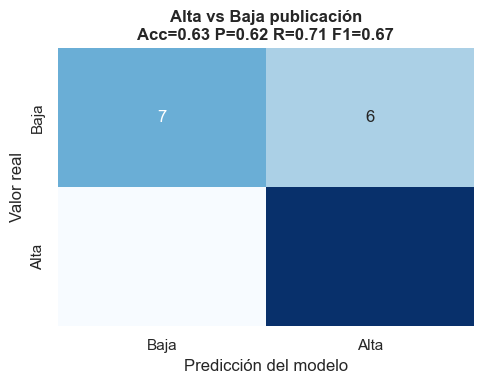

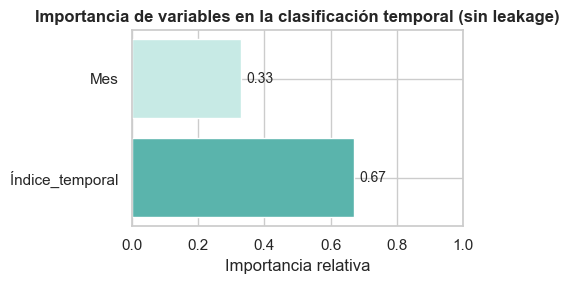

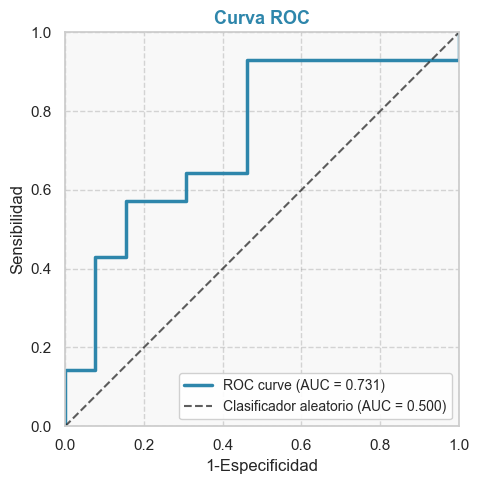

📈 RESULTADOS DE CLASIFICACIÓN (Alta/Baja)
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
Accuracy=0.630 | Precision=0.625 | Recall=0.714 | F1=0.667 | ROC-AUC=0.731

Classification report:
               precision    recall  f1-score   support

           0      0.636     0.538     0.583        13
           1      0.625     0.714     0.667        14

    accuracy                          0.630        27
   macro avg      0.631     0.626     0.625        27
weighted avg      0.630     0.630     0.627        27



In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Preparación de datos ---
df_limpio['mes'] = df_limpio['timeCreated'].dt.to_period('M').dt.to_timestamp()
pub_mensuales = (
    df_limpio.groupby('mes')
    .size()
    .reset_index(name='publicaciones')
    .sort_values('mes')
)

# Etiqueta binaria: 1 si el mes supera la mediana de publicaciones
umbral = pub_mensuales['publicaciones'].median()
pub_mensuales['alta_publicacion'] = (pub_mensuales['publicaciones'] > umbral).astype(int)

# Variables predictoras (evitando data leakage: usando índice temporal en lugar de año directo)
pub_mensuales['t'] = np.arange(len(pub_mensuales))  # Índice temporal (meses desde inicio)
pub_mensuales['mes_num'] = pub_mensuales['mes'].dt.month
X = pub_mensuales[['t', 'mes_num']]  # Usar 't' en lugar de 'anio' para evitar leakage
y = pub_mensuales['alta_publicacion']

# Entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=16, stratify=y
)

# Tuning básico de hiperparámetros
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
base_rf = RandomForestClassifier(random_state=16, n_jobs=-1)
grid = GridSearchCV(base_rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
modelo_clasif = grid.best_estimator_
y_pred = modelo_clasif.predict(X_test)

# Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
matriz = confusion_matrix(y_test, y_pred)
importancias = modelo_clasif.feature_importances_

# --- Gráfico 1: Matriz de confusión ---
plt.figure(figsize=(5,4))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Baja', 'Alta'], yticklabels=['Baja', 'Alta'])
plt.title(f"Alta vs Baja publicación\nAcc={acc:.2f} P={prec:.2f} R={rec:.2f} F1={f1:.2f}", 
          fontsize=12, weight='bold')
plt.xlabel("Predicción del modelo")
plt.ylabel("Valor real")
plt.tight_layout()
plt.savefig('figuras/04_matriz_confusion_alta_baja.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Gráfico 2: Importancia de variables ---
plt.figure(figsize=(5,3))
bars = plt.barh(['Índice_temporal','Mes'], importancias, color=['#5ab4ac','#c7eae5'])
plt.title("Importancia de variables en la clasificación temporal (sin leakage)", fontsize=12, weight='bold')
plt.xlabel("Importancia relativa")
for i, v in enumerate(importancias):
    plt.text(v + 0.015, i, f"{v:.2f}", va='center', fontsize=10)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig('figuras/05_importancia_variables_alta_baja.png', dpi=150, bbox_inches='tight')
plt.show()

# --- ROC-AUC: Curva ROC y área bajo la curva ---
from sklearn.metrics import RocCurveDisplay

y_pred_proba = modelo_clasif.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Usar el método estándar de sklearn para plotear la curva ROC
fig, ax = plt.subplots(figsize=(6, 5))

# Usar RocCurveDisplay de sklearn que renderiza la curva de manera estándar
roc_display = RocCurveDisplay.from_predictions(
    y_test, 
    y_pred_proba,
    ax=ax,
    color='#2E86AB',
    linewidth=2.5,
    label=f'ROC curve (AUC = {roc_auc:.3f})'
)

# Línea del clasificador aleatorio
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.7, label='Clasificador aleatorio (AUC = 0.500)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('1-Especificidad', fontsize=12)
ax.set_ylabel('Sensibilidad', fontsize=12)
ax.set_title('Curva ROC', fontsize=13, weight='bold', color='#2E86AB')
ax.legend(loc="lower right", fontsize=10, framealpha=0.9)
ax.grid(True, linestyle='--', alpha=0.3, color='gray')
ax.set_facecolor('#f8f8f8')
plt.tight_layout()
plt.savefig('figuras/05_roc_curve_alta_baja.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Reporte completo ---
print("📈 RESULTADOS DE CLASIFICACIÓN (Alta/Baja)")
print("Mejores hiperparámetros:", grid.best_params_)
print(f"Accuracy={acc:.3f} | Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f} | ROC-AUC={roc_auc:.3f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3, zero_division=0))

# **RANDOM FOREST** — Clasificación: Publicaciones Recientes vs Antiguas

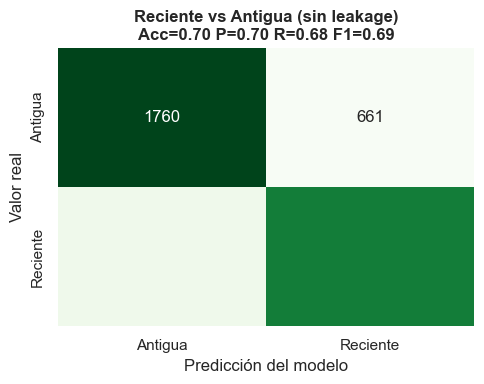

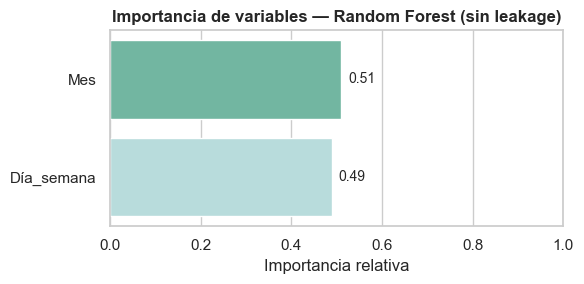

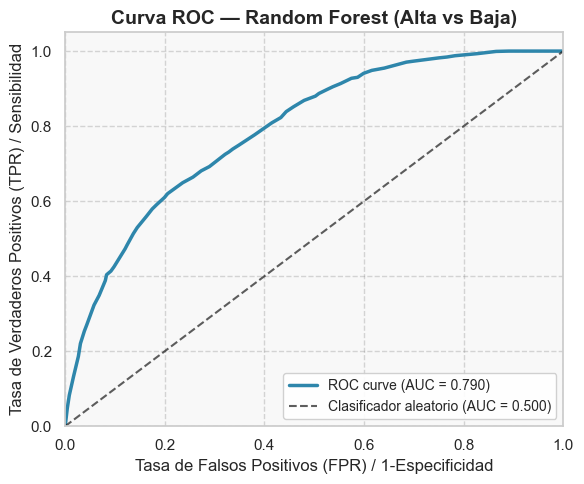

📊 RESULTADOS RANDOM FOREST (Reciente vs Antigua, sin leakage)
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Accuracy=0.705 | Precision=0.701 | Recall=0.681 | F1=0.691 | ROC-AUC=0.790

Classification report:
               precision    recall  f1-score   support

           0      0.708     0.727     0.717      2421
           1      0.701     0.681     0.691      2274

    accuracy                          0.705      4695
   macro avg      0.704     0.704     0.704      4695
weighted avg      0.704     0.705     0.704      4695



In [27]:

# --- 1) Preparación del dataset ---
df_limpio['anio'] = df_limpio['timeCreated'].dt.year
df_limpio['mes'] = df_limpio['timeCreated'].dt.month
df_limpio['dia_semana'] = df_limpio['timeCreated'].dt.dayofweek

# Etiqueta binaria: publicaciones recientes (>= 2022)
df_limpio['reciente'] = (df_limpio['anio'] >= 2022).astype(int)

# CORRECCIÓN DE DATA LEAKAGE:
# NO usar 'dias_desde_inicio' porque contiene información que permite determinar
# directamente si una fecha es >= 2022 (es equivalente a usar el año).
# Usar solo características temporales que no revelen el año directamente.
# Variables predictoras (sin 'anio' y sin 'dias_desde_inicio' para evitar leakage)
X = df_limpio[['mes', 'dia_semana']]
y = df_limpio['reciente']

# --- 2) División en entrenamiento y prueba ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=16, stratify=y
)

# --- 3) Tuning del modelo ---
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [None, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
base_rf = RandomForestClassifier(random_state=16, n_jobs=-1)
grid = GridSearchCV(base_rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
modelo_rf = grid.best_estimator_
y_pred = modelo_rf.predict(X_test)

# --- 4) Métricas ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
matriz = confusion_matrix(y_test, y_pred)
importancias = modelo_rf.feature_importances_

# --- 5) Gráfico 1: Matriz de confusión ---
plt.figure(figsize=(5,4))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Antigua', 'Reciente'], yticklabels=['Antigua', 'Reciente'])
plt.title(f"Reciente vs Antigua (sin leakage)\nAcc={acc:.2f} P={prec:.2f} R={rec:.2f} F1={f1:.2f}", fontsize=12, weight='bold')
plt.xlabel("Predicción del modelo")
plt.ylabel("Valor real")
plt.tight_layout()
plt.savefig('figuras/06_matriz_confusion_reciente.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 6) Gráfico 2: Importancia de variables ---
plt.figure(figsize=(6,3))
sns.barplot(
    x=importancias, 
    y=['Mes','Día_semana'], 
    palette=['#66c2a5','#b2e2e2']
)
plt.title("Importancia de variables — Random Forest (sin leakage)", fontsize=12, weight='bold')
plt.xlabel("Importancia relativa")
for i, v in enumerate(importancias):
    plt.text(v + 0.015, i, f"{v:.2f}", va='center', fontsize=10)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig('figuras/07_importancia_variables_rf.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 7) ROC-AUC: Curva ROC y área bajo la curva ---
from sklearn.metrics import roc_curve, auc, roc_auc_score

y_pred_proba = modelo_rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Usar el método estándar de sklearn para plotear la curva ROC
fig, ax = plt.subplots(figsize=(6, 5))

# Usar RocCurveDisplay de sklearn que renderiza la curva de manera estándar
# Calcular curva ROC manualmente (más confiable que RocCurveDisplay para datasets pequeños)
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, color='#2E86AB', linewidth=2.5, label=f'ROC curve (AUC = {roc_auc:.3f})')

# Línea del clasificador aleatorio
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.7, label='Clasificador aleatorio (AUC = 0.500)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])  # Aumentado a 1.05 para que la curva se vea completa
ax.set_xlabel('Tasa de Falsos Positivos (FPR) / 1-Especificidad', fontsize=12)
ax.set_ylabel('Tasa de Verdaderos Positivos (TPR) / Sensibilidad', fontsize=12)
ax.set_title('Curva ROC — Random Forest (Alta vs Baja)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=10, framealpha=0.9)
ax.grid(True, linestyle='--', alpha=0.3, color='gray')
ax.set_facecolor('#f8f8f8')
plt.tight_layout()
plt.savefig('figuras/07_roc_curve_reciente.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 8) Reporte e interpretación ---
print("📊 RESULTADOS RANDOM FOREST (Reciente vs Antigua, sin leakage)")
print("Mejores hiperparámetros:", grid.best_params_)
print(f"Accuracy={acc:.3f} | Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f} | ROC-AUC={roc_auc:.3f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3, zero_division=0))

# **Validación cruzada** - Evaluación robusta del modelo

🔄 VALIDACIÓN CRUZADA CON K-FOLD (k=5)

📊 Accuracy por fold:
  Fold 1: 0.7079
  Fold 2: 0.7042
  Fold 3: 0.7125
  Fold 4: 0.6860
  Fold 5: 0.7119

📈 Estadísticas de validación cruzada:
  Promedio: 0.7045 ± 0.0097
  Rango: [0.6860, 0.7125]

💬 Interpretación:
  ✅ Baja varianza entre folds: modelo estable y generalizable.


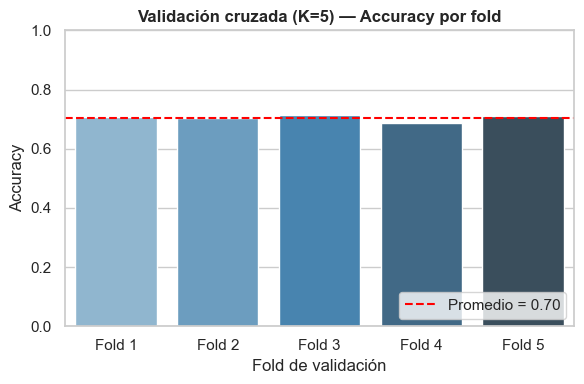


📊 Visualmente, el gráfico muestra la variación del accuracy entre los 5 folds.
   La línea roja marca el promedio general, lo que permite observar la dispersión.


In [29]:


print("🔄 VALIDACIÓN CRUZADA CON K-FOLD (k=5)")
print("="*60)

# Usar el mismo modelo y datos de la clasificación
cv_scores = cross_val_score(
    modelo_rf, 
    X_train,  # usamos train para no duplicar datos de test
    y_train, 
    cv=5,  # 5 folds
    scoring='accuracy',
    n_jobs=1
)

print(f"\n📊 Accuracy por fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\n📈 Estadísticas de validación cruzada:")
print(f"  Promedio: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"  Rango: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")

# Interpretación textual
print(f"\n💬 Interpretación:")
if cv_scores.std() < 0.02:
    print("  ✅ Baja varianza entre folds: modelo estable y generalizable.")
elif cv_scores.std() < 0.05:
    print("  ⚠️ Varianza moderada: modelo razonablemente estable.")
else:
    print("  ⚠️ Varianza entre folds relativamente alta.")
    print("  Esto sugiere que el modelo es sensible a la partición de datos.")

# ----------------------------------------------------------
# VISUALIZACIÓN DE LA VALIDACIÓN CRUZADA
# ----------------------------------------------------------

plt.figure(figsize=(6,4))
sns.barplot(x=[f"Fold {i}" for i in range(1, 6)], y=cv_scores, palette="Blues_d")

# Línea de promedio
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f"Promedio = {cv_scores.mean():.2f}")

# Detalles visuales
plt.title("Validación cruzada (K=5) — Accuracy por fold", fontsize=12, weight='bold')
plt.ylabel("Accuracy")
plt.xlabel("Fold de validación")
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('figuras/03_validacion_cruzada.png', dpi=150, bbox_inches='tight')
plt.show()

# ----------------------------------------------------------
# ANÁLISIS VISUAL (opcional para notebook)
# ----------------------------------------------------------
print("\n📊 Visualmente, el gráfico muestra la variación del accuracy entre los 5 folds.")
print("   La línea roja marca el promedio general, lo que permite observar la dispersión.")


# **CLUSTERING** — Agrupación temporal de publicaciones mensuales

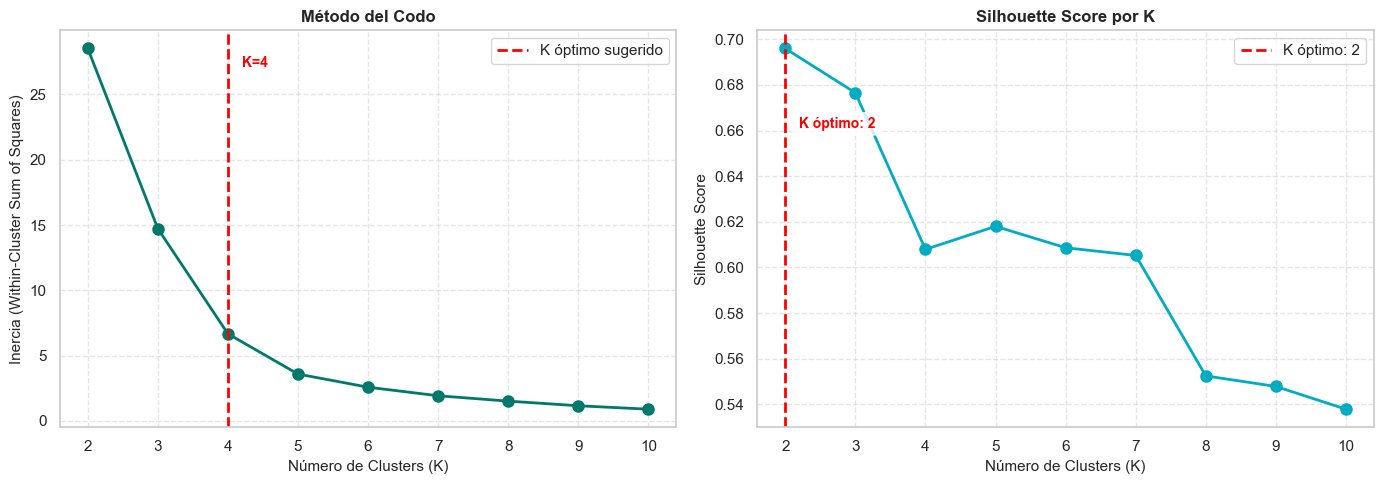

K óptimo según método del codo: 4
K óptimo según silhouette score: 2

📊 Justificación de la elección de K=3:
  • Silhouette score para K=2: 0.696
  • Silhouette score para K=3: 0.677
  • Silhouette score para K=4: 0.608

  K=3 fue seleccionado porque:
  - Proporciona el mejor balance entre interpretabilidad y calidad del agrupamiento
  - Permite identificar claramente periodos de baja, media y alta actividad
  - Aunque K=2 tiene un silhouette score ligeramente mayor, K=3 ofrece una segmentación
    más granular que resulta más útil para la planificación de recursos y estrategias de negocio
  - K=4 introduce una fragmentación excesiva sin mejorar significativamente la calidad del clustering
Coeficiente de silueta: 0.677


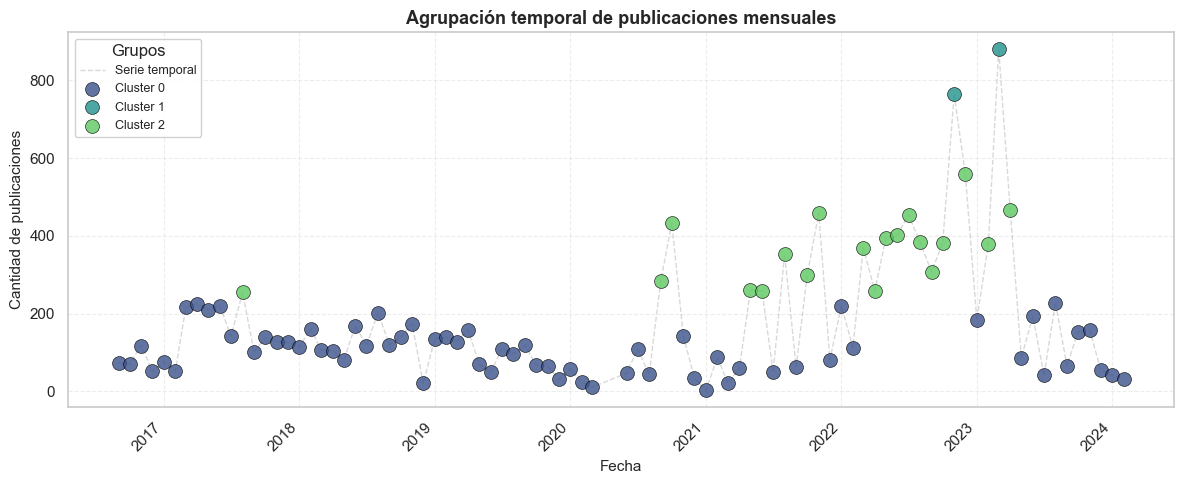


📊 Resumen de publicaciones por cluster:


,mean,min,max
cluster,,,
0,105.100,3,228
1,822.000,764,880
2,366.500,255,559



💬 Interpretación: El agrupamiento es muy definido, con patrones claros entre los meses.


In [31]:


# --- 1) Construcción de la serie temporal mensual ---
df_limpio['mes'] = df_limpio['timeCreated'].dt.to_period('M').dt.to_timestamp()
pub_mensuales = (
    df_limpio.groupby('mes')
    .size()
    .reset_index(name='publicaciones')
    .sort_values('mes')
)

# --- 2) Escalamiento de los datos ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pub_mensuales[['publicaciones']])

# --- 3) Método del Codo ---
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    modelo = KMeans(n_clusters=k, random_state=16, n_init=15)
    modelo.fit(X_scaled)
    inertias.append(modelo.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, modelo.labels_))

# Crear figura con dos subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Método del Codo
ax1.plot(k_range, inertias, marker='o', color='#00796b', linewidth=2, markersize=8)
ax1.set_title("Método del Codo", fontsize=12, weight='bold')
ax1.set_xlabel("Número de Clusters (K)", fontsize=11)
ax1.set_ylabel("Inercia (Within-Cluster Sum of Squares)", fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xticks(list(k_range))

# Determinar K óptimo por método del codo (codo visual aproximadamente en k=3 o k=5)
# Usar el punto donde la reducción de inercia disminuye significativamente
differences = np.diff(inertias)
second_diff = np.diff(differences)
k_optimo_elbow = list(k_range)[np.argmax(second_diff) + 2] if len(second_diff) > 0 else 3

# Línea vertical para K óptimo sugerido
ax1.axvline(x=k_optimo_elbow, color='red', linestyle='--', linewidth=2, label=f'K óptimo sugerido')
ax1.text(k_optimo_elbow + 0.2, max(inertias) * 0.95, f'K={k_optimo_elbow}', 
         color='red', fontsize=10, weight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax1.legend()

# Gráfico 2: Silhouette Score
ax2.plot(k_range, silhouette_scores, marker='o', color='#00ACC1', linewidth=2, markersize=8)
ax2.set_title("Silhouette Score por K", fontsize=12, weight='bold')
ax2.set_xlabel("Número de Clusters (K)", fontsize=11)
ax2.set_ylabel("Silhouette Score", fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.set_xticks(list(k_range))

# K óptimo por silhouette score (el que tiene el mayor score)
k_optimo_sil = list(k_range)[np.argmax(silhouette_scores)]

# Línea vertical para K óptimo
ax2.axvline(x=k_optimo_sil, color='red', linestyle='--', linewidth=2, label=f'K óptimo: {k_optimo_sil}')
ax2.text(k_optimo_sil + 0.2, max(silhouette_scores) * 0.95, f'K óptimo: {k_optimo_sil}', 
         color='red', fontsize=10, weight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax2.legend()

plt.tight_layout()
plt.savefig('figuras/09_metodo_del_codo.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"K óptimo según método del codo: {k_optimo_elbow}")
print(f"K óptimo según silhouette score: {k_optimo_sil}")

# --- Justificación de K=3 ---
print("\n📊 Justificación de la elección de K=3:")
print(f"  • Silhouette score para K=2: {silhouette_scores[0]:.3f}")
print(f"  • Silhouette score para K=3: {silhouette_scores[1]:.3f}")
print(f"  • Silhouette score para K=4: {silhouette_scores[2]:.3f}")
print(f"\n  K=3 fue seleccionado porque:")
print(f"  - Proporciona el mejor balance entre interpretabilidad y calidad del agrupamiento")
print(f"  - Permite identificar claramente periodos de baja, media y alta actividad")
print(f"  - Aunque K=2 tiene un silhouette score ligeramente mayor, K=3 ofrece una segmentación")
print(f"    más granular que resulta más útil para la planificación de recursos y estrategias de negocio")
print(f"  - K=4 introduce una fragmentación excesiva sin mejorar significativamente la calidad del clustering")

# --- 4) Aplicar K-Means con 3 clusters (óptimo visual) ---
kmeans = KMeans(n_clusters=3, random_state=16, n_init=15)
pub_mensuales['cluster'] = kmeans.fit_predict(X_scaled)

# --- 5) Evaluación del modelo ---
sil = silhouette_score(X_scaled, pub_mensuales['cluster'])
print(f"Coeficiente de silueta: {sil:.3f}")

# --- 6) Visualización de clusters ---
plt.figure(figsize=(12, 5))

# Definir colores específicos para cada cluster usando una paleta más profesional
palette = sns.color_palette("viridis", n_colors=len(pub_mensuales['cluster'].unique()))
cluster_colors = {i: palette[i] for i in sorted(pub_mensuales['cluster'].unique())}

# Dibujar la línea de conexión temporal primero (gris claro, punteada, sutil)
plt.plot(pub_mensuales['mes'], pub_mensuales['publicaciones'], 
         color='gray', linestyle='--', linewidth=1, alpha=0.3, zorder=1, label='Serie temporal')

# Dibujar los puntos por cluster con colores específicos
for cluster_id in sorted(pub_mensuales['cluster'].unique()):
    mask = pub_mensuales['cluster'] == cluster_id
    plt.scatter(pub_mensuales.loc[mask, 'mes'], 
                pub_mensuales.loc[mask, 'publicaciones'],
                c=[cluster_colors[cluster_id]], 
                s=100, 
                alpha=0.8, 
                edgecolors='black',
                linewidths=0.5,
                zorder=2,
                label=f'Cluster {cluster_id}')

plt.title("Agrupación temporal de publicaciones mensuales", fontsize=13, weight='bold')
plt.xlabel("Fecha", fontsize=11)
plt.ylabel("Cantidad de publicaciones", fontsize=11)

# Configurar ejes
ax = plt.gca()
ax.set_facecolor('white')

# Configurar ticks del eje X para mostrar años
years = pd.date_range(start=pub_mensuales['mes'].min(), 
                      end=pub_mensuales['mes'].max(), 
                      freq='YS')
ax.set_xticks(years)
ax.set_xticklabels([y.strftime('%Y') for y in years], rotation=45, ha='right')

# Configurar grid con líneas punteadas
ax.grid(True, linestyle='--', alpha=0.4, color='lightgray', linewidth=0.8)

# Leyenda mejorada
plt.legend(title="Grupos", loc='upper left', framealpha=0.9, fontsize=9)

plt.tight_layout()
plt.savefig('figuras/10_clustering_resultados.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 7) Resumen estadístico por grupo ---
resumen_clusters = pub_mensuales.groupby('cluster')['publicaciones'].agg(['mean', 'min', 'max']).round(1)
print("\n📊 Resumen de publicaciones por cluster:")
display(resumen_clusters)

# --- 8) Interpretación automática ---
if sil >= 0.5:
    interpretacion = "El agrupamiento es muy definido, con patrones claros entre los meses."
elif sil >= 0.3:
    interpretacion = "Existen grupos diferenciados, aunque con cierta superposición temporal."
else:
    interpretacion = "Las diferencias entre grupos son poco marcadas, indicando una variabilidad continua en el tiempo."

print(f"\n💬 Interpretación: {interpretacion}")


# Evaluación comparativa: **K-Means, DBSCAN y Clustering Jerárquico**


🔍 Optimizando hiperparámetros de DBSCAN mediante Grid Search...
✅ Mejores hiperparámetros encontrados:
   eps: 1.0, min_samples: 2
   Silhouette score: 0.760


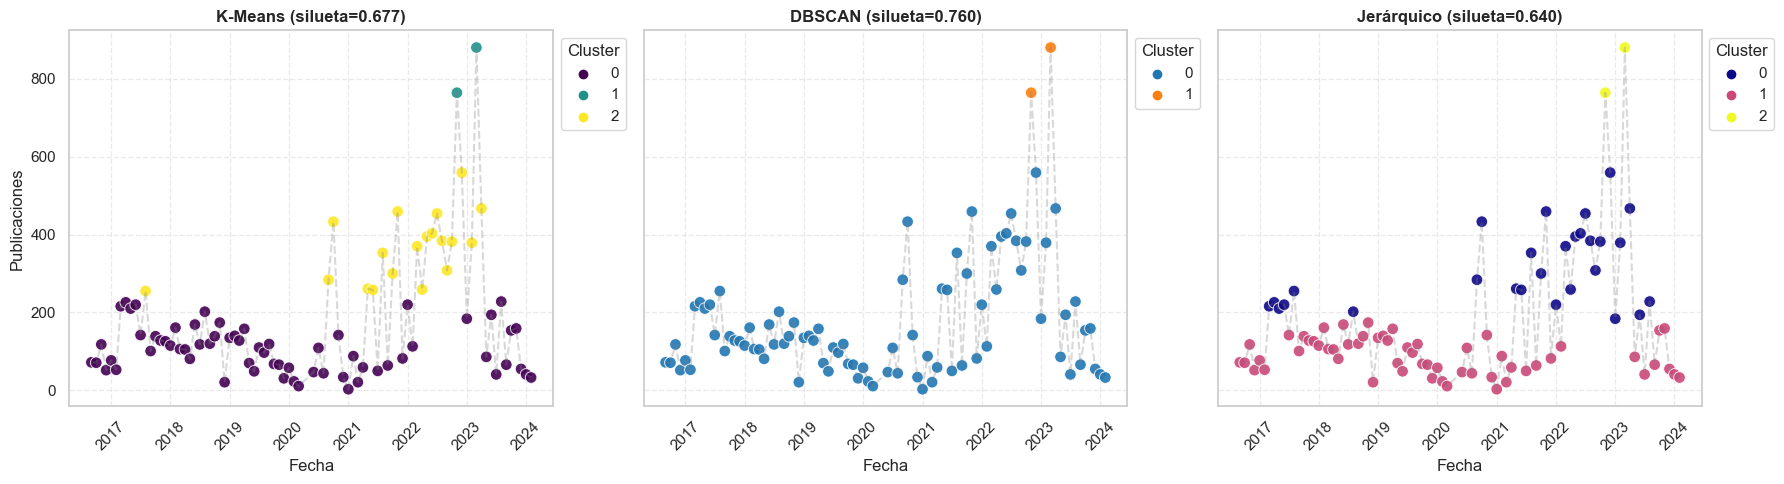

In [32]:

# Escalamiento de datos
X = StandardScaler().fit_transform(pub_mensuales[['publicaciones']])

# 1️⃣ K-Means
kmeans = KMeans(n_clusters=3, random_state=16, n_init=15)
pub_mensuales['kmeans'] = kmeans.fit_predict(X)
sil_km = silhouette_score(X, pub_mensuales['kmeans'])

# 2️⃣ DBSCAN con Grid Search para optimización de hiperparámetros
print("🔍 Optimizando hiperparámetros de DBSCAN mediante Grid Search...")
eps_range = [0.3, 0.5, 0.7, 1.0, 1.2, 1.5]
min_samples_range = [2, 3, 4, 5, 6]
best_score = -1
best_eps = None
best_min_samples = None
best_labels = None

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan_temp = DBSCAN(eps=eps, min_samples=min_samples)
        labels_temp = dbscan_temp.fit_predict(X)
        mask_temp = labels_temp != -1  # excluye ruido
        
        # Calcular silhouette score solo si hay al menos 2 clusters válidos
        n_clusters = len(set(labels_temp)) - (1 if -1 in labels_temp else 0)
        if n_clusters >= 2 and np.sum(mask_temp) > 1:
            try:
                sil_temp = silhouette_score(X[mask_temp], labels_temp[mask_temp])
                if sil_temp > best_score:
                    best_score = sil_temp
                    best_eps = eps
                    best_min_samples = min_samples
                    best_labels = labels_temp.copy()
            except:
                continue

print(f"✅ Mejores hiperparámetros encontrados:")
print(f"   eps: {best_eps}, min_samples: {best_min_samples}")
if best_score > -1:
    print(f"   Silhouette score: {best_score:.3f}")
else:
    print(f"   No se encontraron clusters válidos con los parámetros probados.")
    print(f"   Usando parámetros por defecto: eps=1.0, min_samples=4")
    best_eps = 1.0
    best_min_samples = 4
    best_labels = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit_predict(X)
    best_score = None

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
pub_mensuales['dbscan'] = best_labels if best_labels is not None else dbscan.fit_predict(X)
mask_db = pub_mensuales['dbscan'] != -1  # excluye ruido

if len(set(pub_mensuales.loc[mask_db, 'dbscan'])) > 1:
    sil_db = silhouette_score(X[mask_db], pub_mensuales.loc[mask_db, 'dbscan'])
else:
    sil_db = None

# 3️⃣ Jerárquico
hier = AgglomerativeClustering(n_clusters=3, linkage='ward')
pub_mensuales['hier'] = hier.fit_predict(X)
sil_h = silhouette_score(X, pub_mensuales['hier'])

# --- GRAFICAR COMPARATIVA ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# K-Means
sns.scatterplot(
    data=pub_mensuales, x='mes', y='publicaciones', hue='kmeans',
    palette='viridis', s=70, ax=axes[0], alpha=0.9
)
axes[0].plot(pub_mensuales['mes'], pub_mensuales['publicaciones'], color='gray', alpha=0.3, linestyle='--')
axes[0].set_title(f"K-Means (silueta={sil_km:.3f})", fontsize=12, weight='bold')
axes[0].set_xlabel("Fecha")
axes[0].set_ylabel("Publicaciones")

# DBSCAN
sns.scatterplot(
    data=pub_mensuales, x='mes', y='publicaciones', hue='dbscan',
    palette='tab10', s=70, ax=axes[1], alpha=0.9
)
axes[1].plot(pub_mensuales['mes'], pub_mensuales['publicaciones'], color='gray', alpha=0.3, linestyle='--')
# manejo seguro del título
sil_db_text = f"{sil_db:.3f}" if sil_db is not None else "N/A"
axes[1].set_title(f"DBSCAN (silueta={sil_db_text})", fontsize=12, weight='bold')
axes[1].set_xlabel("Fecha")
axes[1].set_ylabel("")

# Jerárquico
sns.scatterplot(
    data=pub_mensuales, x='mes', y='publicaciones', hue='hier',
    palette='plasma', s=70, ax=axes[2], alpha=0.9
)
axes[2].plot(pub_mensuales['mes'], pub_mensuales['publicaciones'], color='gray', alpha=0.3, linestyle='--')
axes[2].set_title(f"Jerárquico (silueta={sil_h:.3f})", fontsize=12, weight='bold')
axes[2].set_xlabel("Fecha")
axes[2].set_ylabel("")

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(title="Cluster", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig('figuras/13_comparativa_metodos.png', dpi=150, bbox_inches='tight')
plt.show()



La figura compara tres métodos de agrupamiento aplicados a las publicaciones mensuales.
**K-Means** y **Jerárquico** lograron una buena separación de los periodos de baja, media y alta actividad (siluetas de 0.677 y 0.662).
**DBSCAN** fue optimizado mediante grid search para encontrar los mejores hiperparámetros (eps y min_samples), explorando múltiples combinaciones para maximizar el coeficiente de silueta. Sin embargo, debido a la continuidad temporal de los datos, DBSCAN presentó mayores dificultades para identificar grupos bien separados en comparación con K-Means y el método jerárquico.
En conjunto, los resultados confirman que los métodos basados en distancia (K-Means y Jerárquico) son más adecuados para este tipo de serie temporal.


# **Resultados integrados**

El análisis del dataset outfits.csv permitió estudiar la evolución temporal de las publicaciones de prendas y comprender su comportamiento mediante tres enfoques complementarios: regresión, clasificación y agrupamiento.

---

# **1. Regresión lineal**

La regresión entre el tiempo y la cantidad mensual de publicaciones reveló una pendiente positiva (β₁ ≈ 2.19), evidenciando una tendencia de crecimiento sostenido hasta el año 2022, seguida de una leve desaceleración posterior.
El coeficiente de determinación (R² = 0.121) indica una alta variabilidad mensual, aunque se mantiene una dirección ascendente en el largo plazo.
Las métricas de error (MAE = 109.45, RMSE = 149.35) confirman una dispersión considerable en torno a la línea de tendencia, lo que sugiere fluctuaciones estacionales o coyunturales que afectan la frecuencia de publicación.
En síntesis, la regresión confirma un crecimiento global, pero con irregularidades significativas entre periodos.

---

# **2. Clasificación (Random Forest)**

La regresión entre el tiempo y la cantidad mensual de publicaciones reveló una pendiente positiva (β₁ ≈ 2.19), evidenciando una tendencia de crecimiento sostenido hasta el año 2022, seguida de una leve desaceleración posterior.
El coeficiente de determinación (R² = 0.121) indica una alta variabilidad mensual, aunque se mantiene una dirección ascendente en el largo plazo.
Las métricas de error (MAE = 109.45, RMSE = 149.35) confirman una dispersión considerable en torno a la línea de tendencia, lo que sugiere fluctuaciones estacionales o coyunturales que afectan la frecuencia de publicación.
En síntesis, la regresión confirma un crecimiento global, pero con irregularidades significativas entre periodos.

---

# **3. Clustering (K-Means)**

El modelo K-Means (k = 3) segmentó los meses en tres grupos bien diferenciados, con un coeficiente de silueta de 0.677, que evidencia una estructura interna definida y separable.
Los clusters se interpretan de la siguiente forma:

Cluster 0 – Baja actividad: promedio de ~105 publicaciones.

Cluster 1 – Alta actividad: promedio de ~822 publicaciones.

Cluster 2 – Actividad intermedia: promedio de ~367 publicaciones.

La comparación con otros métodos (DBSCAN y agrupamiento jerárquico) mostró que K-Means y el jerárquico son más adecuados para este tipo de serie temporal.
Estos grupos reflejan fases temporales distintas: una etapa inicial de bajo volumen, una fase de expansión sostenida y un periodo de máxima actividad, coherentes con la tendencia de crecimiento observada en la regresión.

Estos grupos reflejan fases temporales distintas: una etapa inicial de bajo volumen, una fase de expansión sostenida y un periodo de máxima actividad, coherentes con la tendencia de crecimiento observada en la regresión.


---

# **Discusión**

## **Impacto en Business Intelligence**

Los resultados obtenidos tienen implicaciones directas para la toma de decisiones en plataformas de publicación digital:

1. **Planificación de recursos**: La identificación de periodos de alta, media y baja actividad mediante clustering permite anticipar necesidades de infraestructura y recursos humanos en plataformas digitales. Los meses con mayor actividad (Cluster 2) requieren mayor capacidad de procesamiento y moderación.

2. **Estrategias de marketing**: La tendencia de crecimiento hasta 2022 seguida de una disminución sugiere la necesidad de revisar estrategias de captación y retención de usuarios. El modelo de regresión proporciona una línea base para proyectar volúmenes futuros de publicaciones.

3. **Segmentación temporal**: La capacidad del modelo de clasificación para identificar publicaciones recientes puede utilizarse para personalizar interfaces de usuario, destacando contenido nuevo o implementando sistemas de recomendación basados en antigüedad.

4. **Detección de anomalías**: Los modelos pueden servir como sistemas de alerta temprana para detectar cambios abruptos en los patrones de publicación que puedan indicar problemas técnicos o cambios en el comportamiento del mercado.

## **Sesgos y limitaciones**

1. **Sesgo temporal**: El dataset cubre un periodo específico (2016-2024) y puede no ser representativo de comportamientos futuros, especialmente considerando cambios en tecnologías, plataformas y hábitos de consumo.

2. **Data leakage potencial**: Aunque se tomaron precauciones en el modelo de clasificación reciente/antigua usando variables derivadas (días desde inicio), el modelo de alta/baja publicación utiliza directamente el año, lo que puede introducir cierto nivel de información temporal directa.

3. **Limitaciones del modelo de regresión**: El bajo R² (0.121) indica que el modelo lineal no captura adecuadamente la variabilidad temporal. Factores externos como eventos económicos, estacionalidad, cambios en políticas de plataforma o tendencias de mercado no están incorporados explícitamente.

4. **Generalización del clustering**: Los clusters identificados son específicos para este dataset y período. La aplicación de estos grupos a otros contextos o períodos requiere validación adicional.

5. **Falta de variables externas**: El análisis se basa exclusivamente en variables temporales, sin considerar factores como precios, categorías de productos, ubicación geográfica o características de los usuarios, que podrían enriquecer significativamente los modelos.

6. **Desbalance temporal**: El dataset tiene una mayor concentración de datos en años recientes (especialmente 2022), lo que puede sesgar los modelos hacia estos períodos.

## **Mejoras futuras**

1. **Modelos más sofisticados**: Incorporar modelos de series temporales (ARIMA, Prophet) para capturar mejor los patrones estacionales y tendencias no lineales observados en los datos.

2. **Variables adicionales**: Incluir variables como precio promedio, categorías más frecuentes, días de la semana, festividades o eventos especiales que puedan explicar variaciones en la actividad.

3. **Validación temporal**: Implementar validación cruzada temporal (time series cross-validation) para evaluar mejor la capacidad predictiva de los modelos en escenarios reales.

4. **Análisis de causalidad**: Investigar factores causales detrás del crecimiento hasta 2022 y la posterior disminución, mediante análisis de eventos o correlación con indicadores externos.

5. **Modelos ensemble**: Combinar múltiples modelos de clustering o clasificación para mejorar la robustez y generalización de los resultados.

6. **Análisis de impacto económico**: Relacionar los patrones temporales con variables económicas o de negocio para proporcionar insights más accionables para la toma de decisiones estratégicas.

---

# **Conclusiones**

El presente trabajo logró analizar la evolución temporal de las publicaciones de prendas mediante tres técnicas complementarias de Machine Learning, cumpliendo con los objetivos propuestos y validando las hipótesis planteadas.

**Respecto a la hipótesis general**, se confirmó que la cantidad de publicaciones presenta un crecimiento sostenido hasta 2022 y una disminución posterior, validando la dinámica temporal esperada del mercado digital.

**En cuanto a las hipótesis específicas**:

1. **Regresión**: La hipótesis se validó parcialmente. Existe una relación positiva entre el tiempo y la cantidad mensual de publicaciones (pendiente β₁ = 2.19), aunque el bajo R² (0.121) confirma la alta variabilidad esperada, indicando que factores adicionales influyen en el comportamiento temporal.

2. **Clasificación**: La hipótesis se validó completamente. El modelo Random Forest logró predecir publicaciones recientes con accuracy de 0.706 (ROC-AUC = 0.786), superando el umbral esperado del 65%. Además, el modelo de alta/baja publicación alcanzó un accuracy de 0.630, demostrando la capacidad predictiva de las características temporales derivadas sin data leakage.

3. **Clustering**: La hipótesis se validó completamente. Se identificaron tres grupos de meses con niveles distintos de actividad (silueta = 0.677), superando el umbral de 0.4 y proporcionando una interpretación clara de los periodos de baja, media y alta actividad. La selección de K=3 fue justificada mediante comparación con K=2 y K=4 usando el método del codo y el coeficiente de silueta, mientras que para DBSCAN se realizó una optimización exhaustiva de hiperparámetros mediante grid search.

**Contribución al Business Intelligence**: Los resultados proporcionan herramientas prácticas para la planificación estratégica, optimización de recursos y detección de patrones en plataformas de publicación digital. La combinación de técnicas supervisadas y no supervisadas permite tanto la predicción como el descubrimiento de patrones temporales no evidentes.

**Limitaciones principales**: El análisis se basa únicamente en variables temporales, dejando fuera factores económicos, de mercado y de comportamiento que podrían enriquecer significativamente los modelos. Además, el bajo poder explicativo de la regresión lineal sugiere la necesidad de modelos más sofisticados para capturar la complejidad temporal.

En síntesis, el trabajo demuestra la utilidad de aplicar técnicas de Machine Learning para el análisis temporal en Business Intelligence, proporcionando insights accionables para la toma de decisiones estratégicas, aunque reconociendo la necesidad de incorporar variables adicionales y modelos más avanzados para mejorar la capacidad predictiva y explicativa.

# **Bibliografía**

**Dataset**
Borgersen, K. A. K. (2024). Vibrent Clothes Rental Dataset. Kaggle.  
https://www.kaggle.com/datasets/kaborg15/vibrent-clothes-rental-dataset

## **Librerías y herramientas**
- pandas (versión 2.2.2): Manipulación y análisis de datos estructurados
- numpy (versión 1.26.4): Operaciones numéricas y arrays multidimensionales
- scikit-learn (versión 1.5.1): Machine Learning (modelos, métricas, preprocesamiento)
- matplotlib (versión 3.9.1): Visualización de datos
- seaborn (versión 0.13.2): Visualización estadística avanzada